<h1><center> Práctica de Teoría de la Información</center></h1>


<h3><center>María Barroso Honrubia y Gloria del Valle Cano</center></h3>

En esta práctica se aplican técnicas de Teoría de la Información con el objetivo de estudiar la transmisión de información mutua entre dos neuronas principales, LP (Lateral Pyloric Neuron) y VD (Ventricular Dilator Neuron), las cuales pertenecen al sistema nervioso de un cangrejo. Gracias a la aportación de los datos facilitados de la sinapsis, se pueden distinguir las diferentes etapas en cada una de las neuronas:

* Control: etapa donde se mide el potencial de las neuronas en su estado inicial.
* Inyección de GABA: etapa donde se mide el potencial tras haber inyectado ácido $\gamma$-aminobutírico.
* Recuperación: etapa donde se mide el potencial de las neuronas tras dejar el sistema en reposo.

De esta manera estudiaremos la transmisión de información mutua tras un análisis completo de estas series, asumiendo, en un primer análisis, que los disparos neuronales o *spikes* (aumentos rápidos del potencial) son los eventos que inicialmente tienen la información. En un segundo análisis, se considerarán los *bursts* (agrupaciones de spikes) como los eventos que contienen la información del sistema y se compararán los resultados obtenidos.

## 0. Importación de librerías

In [1]:
import math
import json
import zipfile
import pandas as pd
import numpy as np

from io import BytesIO
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from skimage.util import view_as_windows
from collections import defaultdict

file_path = '../../DatosSinapsisArtificial'
neurons = ['LP','VD']

## 1. Carga de datos
Implementamos la función **zip_to_dataframe** para cargar los datos de la sinapsis conviertiendo las señales de las neuronas en un *Dataframe* de *pandas* para así manipularlas facilmente. Por su parte, la función **load_data** devuelve información del Dataframe obtenido para las diferentes etapas de la sinapsis.

In [2]:
def zip_to_dataframe(file_path, file_name, neurons):
    """
    Load data from zip to pandas dataframe.
    Args:
        file_path (str): path to file
        file_name (str): file name (TrozoC, TrozoG or TrozoR)
        neurons: neurons name
    """
    file_path_zip = f'{file_path}/{file_name}.zip'
    file_name_txt = f'{file_name}.txt'
    with zipfile.ZipFile(file_path_zip) as thezip:
        with thezip.open(file_name_txt, mode='r') as thefile:
            data = thefile.read()
            return pd.read_csv(BytesIO(data), sep='\t', index_col=False, names=neurons, skiprows=range(3), decimal=',')
        
def load_data(file_path, file_name, neurons):
    """
    Load data and show main information.
    Args:
        file_path (str): path to file
        file_name (str): file name (TrozoC, TrozoG or TrozoR)
        neurons: neurons name
    """
    print("________________ {0} ________________".format(file_name))
    chunk = zip_to_dataframe(file_path, file_name, neurons)
    print(chunk.head())
    print('Number of channels: {0}'.format(len(chunk.columns)))
    print('Number of samples per channel: {0}\n'.format(len(chunk)))
    return chunk

In [3]:
trozoC = load_data(file_path, 'TrozoC', neurons)
trozoG = load_data(file_path, 'TrozoG', neurons)
trozoR = load_data(file_path, 'TrozoR', neurons)

________________ TrozoC ________________
         LP        VD
0  0.004883  0.015259
1  0.001526  0.024109
2 -0.010681  0.031128
3 -0.022278  0.041809
4 -0.028076  0.045471
Number of channels: 2
Number of samples per channel: 19847700

________________ TrozoG ________________


/home/maria/main/main/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


         LP        VD
0 -0.006104  0.064697
1 -0.004272  0.075989
2 -0.003357  0.087280
3 -0.005188  0.092468
4 -0.007324  0.093384
Number of channels: 2
Number of samples per channel: 16384000

________________ TrozoR ________________
         LP        VD
0 -0.008240  0.084534
1 -0.009460  0.070190
2 -0.014038  0.049133
3 -0.021973  0.035400
4 -0.035095  0.022888
Number of channels: 2
Number of samples per channel: 16384000



## 2. Análisis de los datos a través de Spikes

### 2.1. Análisis de cada uno de los trozos

Para comenzar el análisis, representamos las señales de las neuronas VD y LP de cada etapa hasta el instante 5000, teniendo en cuenta que los registros de las señales se tomaron en intervalos de 0.1. De esta manera se representan un total de 50000 registros. En las gráficas de cada una de las etapas se ven claramente aumentos del potencial, que serán los eventos utilizados para interpretar la transmisión de información entre neuronas.

In [4]:
def chunk_analysis(chunk, name, n, dt):
    """
        Shows relevant information from file name selected.
        Args:
            chunk (Dataframe): dataframe to analyze (TrozoC, TrozoG or TrozoR)
            n (int): numer of data points
            dt (float): interval
    """
    t = np.arange(0, n*dt, dt)

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, constrained_layout=True)
    fig.set_size_inches(16, 8)
    fig.suptitle('{0}'.format(name), fontsize=20)

    ax1.grid(True)
    ax1.plot(t, chunk.LP.iloc[:n], lw=0.4)
    ax1.set_title('LP', fontsize=16)
    
    ax2.grid(True)
    ax2.plot(t, chunk.VD.iloc[:n],'tab:orange', lw=0.4)
    ax2.set_title('VD', fontsize=16)

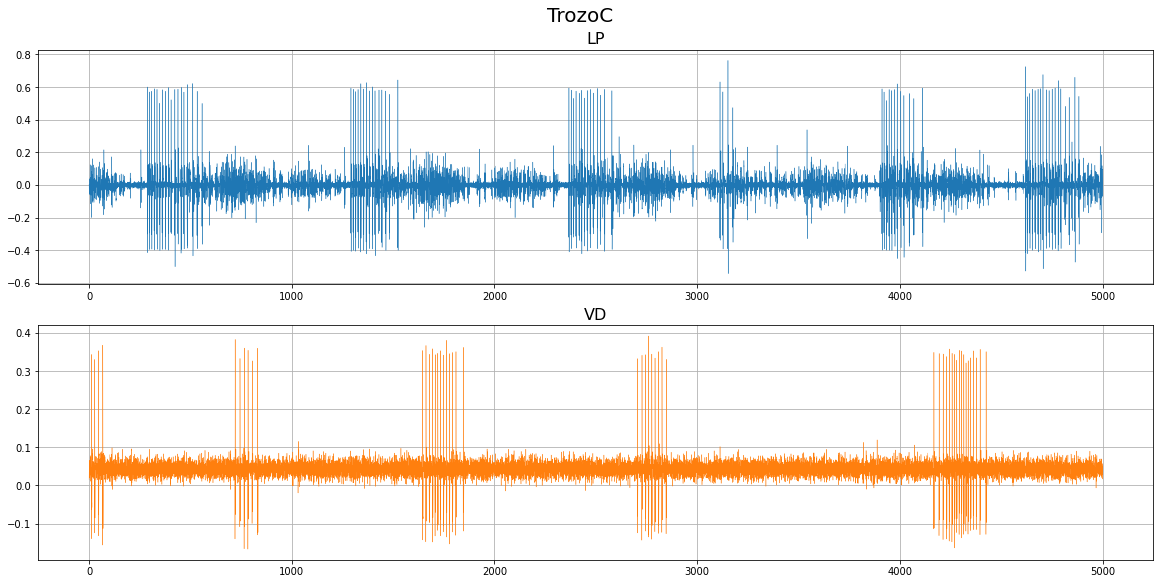

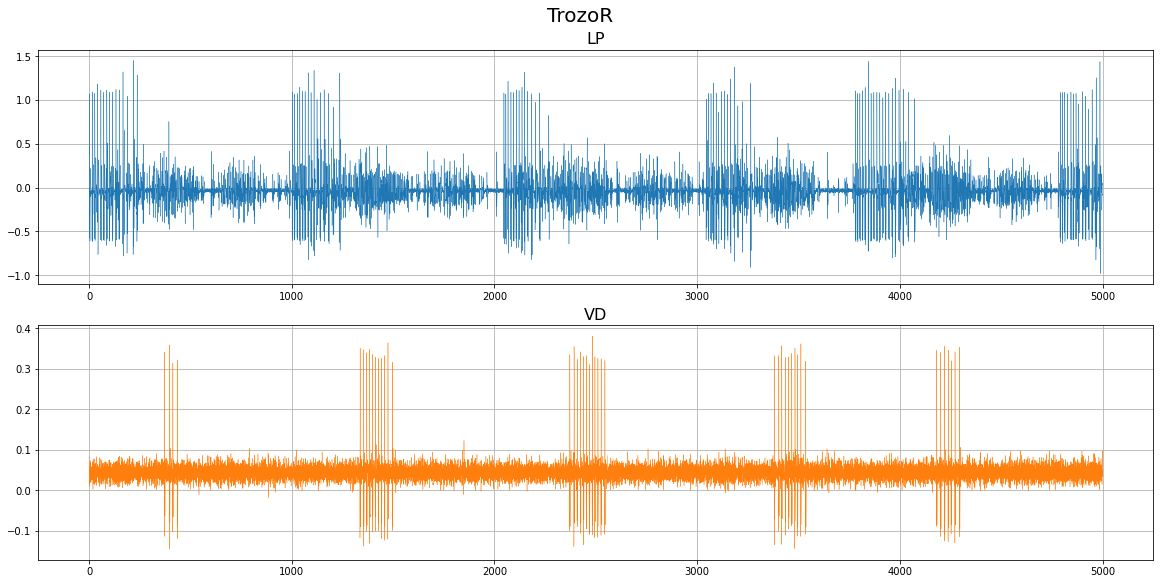

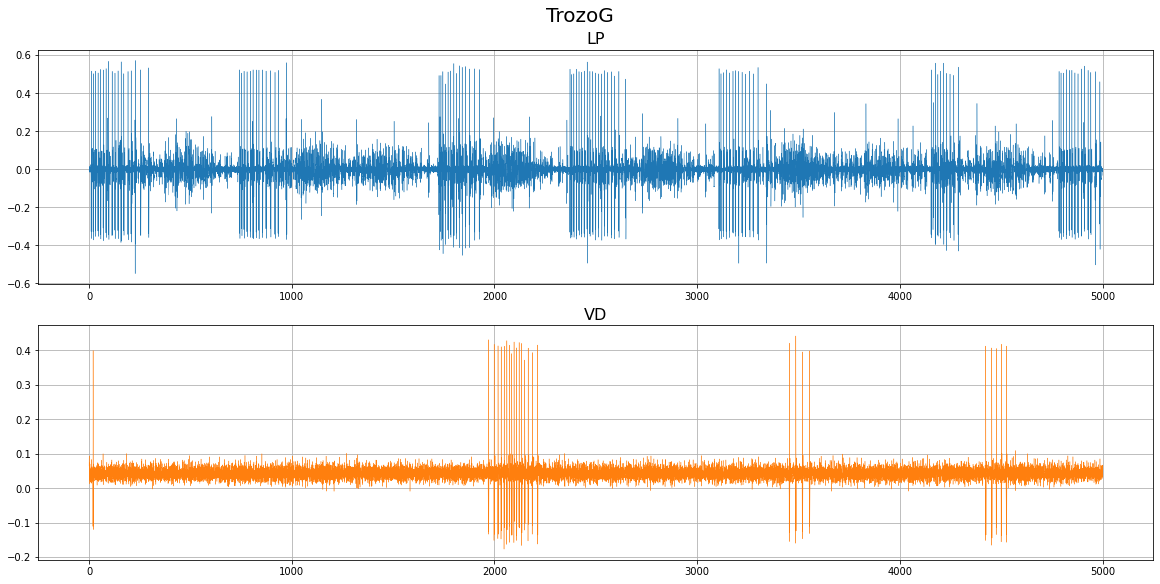

In [5]:
n = 50000
dt = 0.1
chunk_analysis(trozoC, 'TrozoC', n, dt)
chunk_analysis(trozoR, 'TrozoR', n, dt)
chunk_analysis(trozoG, 'TrozoG', n, dt)

### 2.2. Detección de Spikes

Como se ha comentado, para este primer análisis se ha decidido utilizar como evento de información los *spikes* (aumento rápido del potencial). Por tanto, el primer paso de nuestro análisis será definir un umbral que nos permita detectar estos eventos. 

El método utilizado para ello será una variante de un método estadístico utilizado para detectar datos atípico o *outliers*. A partir del cálculo de la media y la desviación típica de los datos, si un valor está a un cierto número de desviaciones típicas de la media, se considerará como un valor atípico. En estadística se utilizan un total de 3 desviaciones típicas de la media para detectar los outliers.


Sin embargo, al observar la distribución de nuestros datos, vemos que el rango intercuartílico (Q3 - Q1) es muy estrecho y este método detectaría un mayor número de datos atípicos. Por tanto, en nuestra versión, implementada en **get_threshold** hemos decidido utilizar un total de 4.5 desviaciones estándar, esto es
$$
\begin{equation*}
    \mu \pm 4.5\sigma
\end{equation*}
$$

________________ TrozoC ________________
                 LP            VD
count  1.984770e+07  1.984770e+07
mean  -2.253853e-08  4.385849e-02
std    8.214042e-02  3.287948e-02
min   -7.101440e-01 -2.170715e+00
25%   -2.288800e-02  3.295900e-02
50%    3.050000e-04  4.364000e-02
75%    2.410900e-02  5.401600e-02
max    9.344480e-01  1.351624e+00


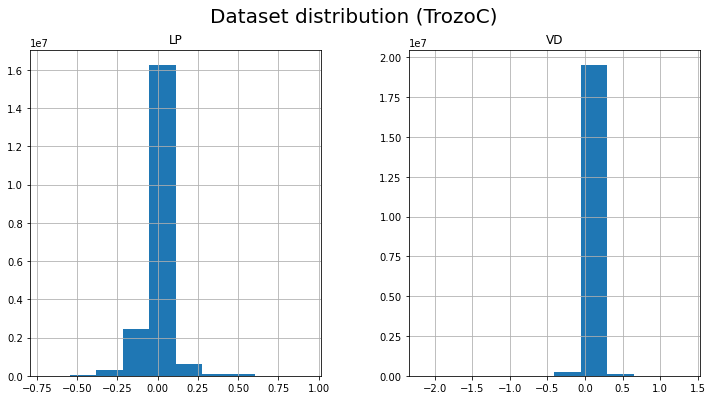

Threshold for each neuron (TrozoC):
LP    0.37
VD    0.20
dtype: float64
________________ TrozoG ________________
                 LP            VD
count  1.638400e+07  1.638400e+07
mean   1.782227e-11  4.330900e-02
std    8.109792e-02  3.337760e-02
min   -6.420900e-01 -3.088380e-01
25%   -2.624500e-02  3.326400e-02
50%    0.000000e+00  4.303000e-02
75%    2.441400e-02  5.310100e-02
max    9.265140e-01  5.520630e-01


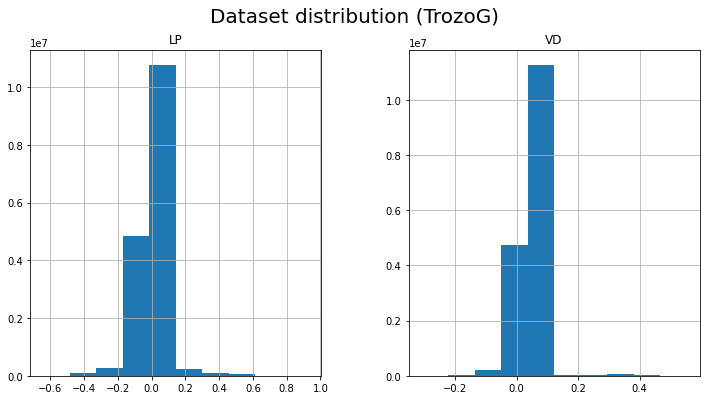

Threshold for each neuron (TrozoG):
LP    0.37
VD    0.20
dtype: float64
________________ TrozoR ________________
                 LP            VD
count  1.638400e+07  1.638400e+07
mean  -3.341000e-02  4.389221e-02
std    1.948664e-01  3.313382e-02
min   -1.328430e+00 -2.170715e+00
25%   -1.058960e-01  3.295900e-02
50%   -3.662100e-02  4.364000e-02
75%    1.770000e-02  5.432100e-02
max    1.992188e+00  1.351624e+00


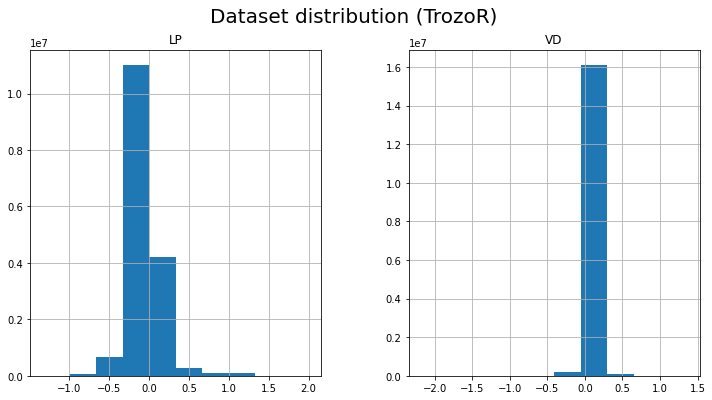

Threshold for each neuron (TrozoR):
LP    0.85
VD    0.20
dtype: float64


In [6]:
def get_threshold(df, precision=2):
    """
        returns threshold from the method described above.
        Args:
            df (Dataframe): dataframe to analyze (TrozoC, TrozoG or TrozoR)
            precision (int): number of decimals to round
    """
    r = df.mean() + 4.5*df.std()
    return np.round(r + 0.5 * 10**(-precision), precision)

def get_spikes(chunk, name):
    """
        returns and shows thresholds.
        Args:
            chunk (Dataframe): dataframe to analyze (TrozoC, TrozoG or TrozoR)
            name (str): name of chunk to analyze
    """
    print("________________ {0} ________________".format(name))
    print("{0}".format(chunk.describe()))
    histogram = chunk.hist(figsize = (12, 6))
    plt.suptitle('Dataset distribution ({0})'.format(name), fontsize=20)
    plt.show()
    
    threshold = get_threshold(chunk)
    print('Threshold for each neuron ({0}):'.format(name))
    print('{0}'.format(threshold))
    return threshold

thresholdC = get_spikes(trozoC, 'TrozoC')
thresholdG = get_spikes(trozoG, 'TrozoG')
thresholdR = get_spikes(trozoR, 'TrozoR')

Definidos los umbrales para cada neurona en cada etapa, utilizamos la propia función **find_peaks** de *scipy* que encuentra de manera eficiente todos los spikes de una señal que superen un umbral pasado por argumento y que se encuentren a una cierta distancia. En una primera versión de los spikes, asumiremos que la distancia mínima entre spike puede ser mayor o igual a 1. Sin embargo, veremos que así se obtiene un gran número de spikes y en muchas ocasiones estemos contabilizando spikes distintos que debido al umbral que hemos establecido se deban a un mismo aumento de potencial.

________________ TrozoC ________________
Total events (LP): 31231
Total events (VD): 22335
________________ TrozoG ________________
Total events (LP): 26633
Total events (VD): 15662
________________ TrozoR ________________
Total events (LP): 24961
Total events (VD): 18674


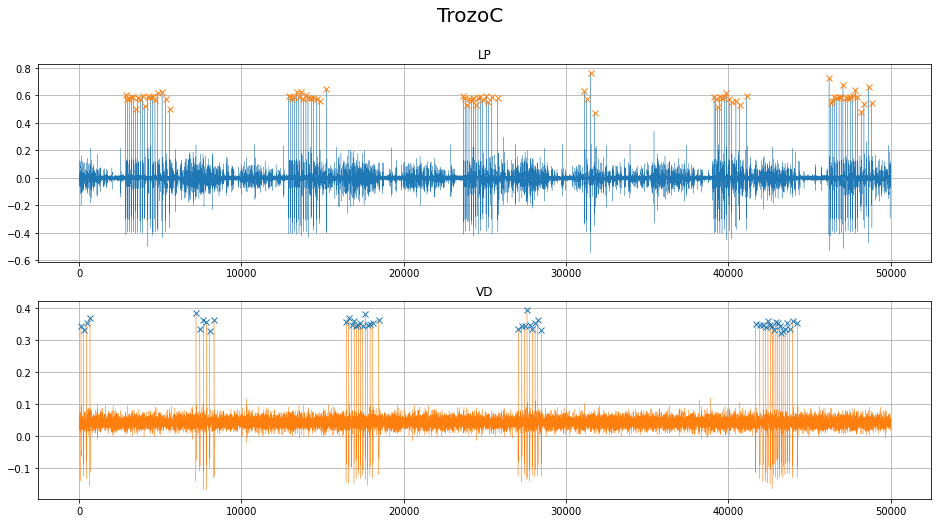

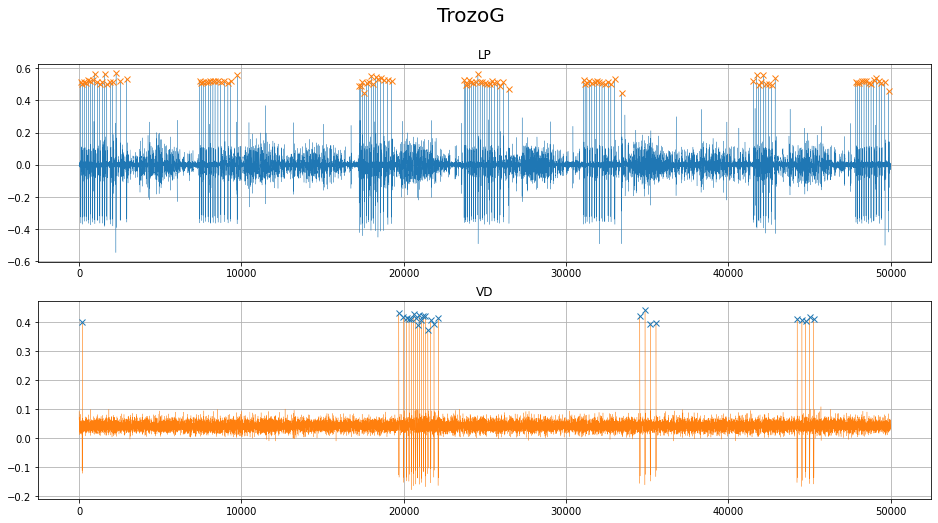

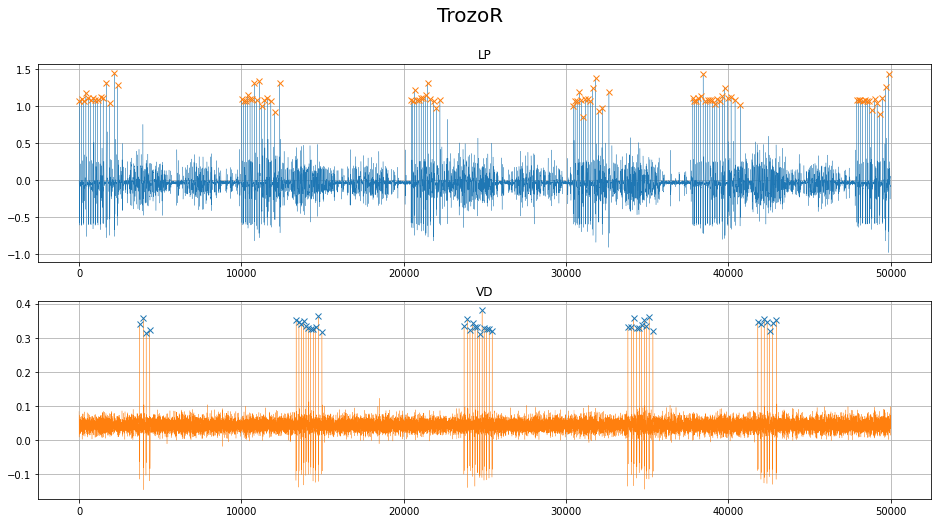

In [7]:
def find_events(chunk, name, threshold, distance=1, n=50000):
    """
        returns index of spikes found and show spikes.
        Args:
            chunk (Dataframe): dataframe to analyze (TrozoC, TrozoG or TrozoR)
            threshold (float): threshold of spikes
            distance (int): minimum distance between spikes
            name (str): name of chunk to analyze
            n (int): size of signal to show
    """

    print("________________ {0} ________________".format(name))
    lp_events, _ = find_peaks(chunk.LP[:n], threshold[0], distance = distance)
    vd_events, _ = find_peaks(chunk.VD[:n], threshold[1], distance = distance)
    
    t_lp,_ = find_peaks(chunk.LP, threshold[0],distance = distance)
    t_vd,_ = find_peaks(chunk.VD, threshold[1],distance = distance)
    print("Total events (LP): {0}".format(len(t_lp)))
    print("Total events (VD): {0}".format(len(t_vd)))
    
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_size_inches(16, 8)
    fig.suptitle('{0}'.format(name), fontsize=20)

    ax1.plot(chunk.LP[:n], lw=0.3)
    ax1.plot(lp_events, chunk.LP[:n][lp_events], "x")
    ax1.set_title("LP")
    ax1.grid(True)

    ax2.plot(chunk.VD[:n],'tab:orange', lw=0.3)
    ax2.plot(vd_events, chunk.VD[:n][vd_events], "x")
    ax2.set_title("VD")
    ax2.grid(True)
    
    return t_lp, t_vd


lp_spikes_C, vd_spikes_C = find_events(trozoC, 'TrozoC', thresholdC)
lp_spikes_G, vd_spikes_G = find_events(trozoG, 'TrozoG', thresholdG)
lp_spikes_R, vd_spikes_R = find_events(trozoR, 'TrozoR', thresholdR)

A continuación, estudiaremos la distribución que siguen las distancias entre spikes con el fin de detectar aquellos spikes cuya distancia sea demasiado próxima y pueda tratarse del propio ruido de los datos y de nuestra elección de umbral. Para ello, mostraremos un resumen de las estadísticas de esta distribución: distancias mínimas, máximas, media, medianas, así como el quantil 0.0025, es decir, la distancia que deja el 0.25% de los datos a la izquierda.  

________________ TrozoC ________________
________ LP ________
Min: 3
Max: 22323
Mean: 635.3495036823567
Medium: 154.0
Q1: 24.80725
________ VD ________
Min: 4
Max: 29910
Mean: 888.3783469150175
Medium: 160.0
Q1: 17.1665
________________ TrozoG ________________
________ LP ________
Min: 4
Max: 14121
Mean: 614.9039876839892
Medium: 155.0
Q1: 24.65775
________ VD ________
Min: 2
Max: 21409
Mean: 1045.8287465679075
Medium: 191.0
Q1: 62.915
________________ TrozoR ________________
________ LP ________
Min: 40
Max: 23023
Mean: 656.3359375
Medium: 155.0
Q1: 41.23975
________ VD ________
Min: 4
Max: 29910
Mean: 877.213677502276
Medium: 159.0
Q1: 14.008000000000001


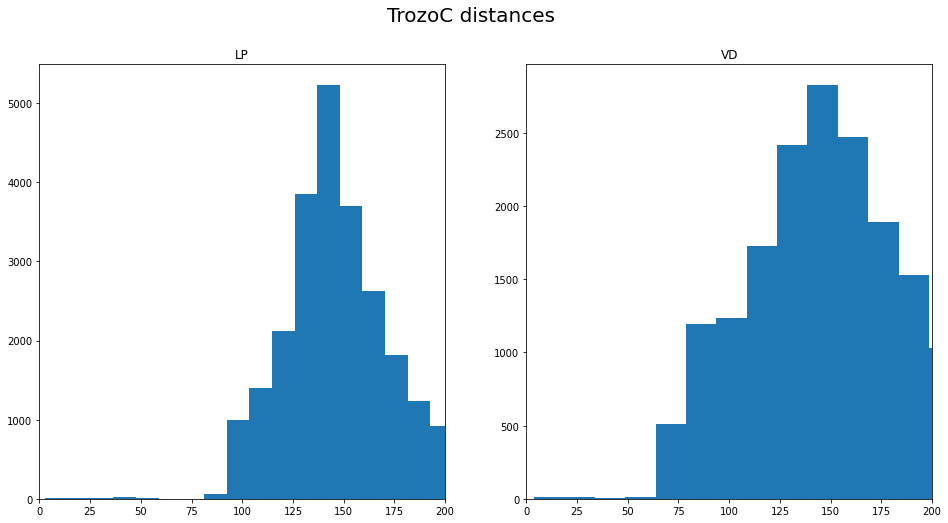

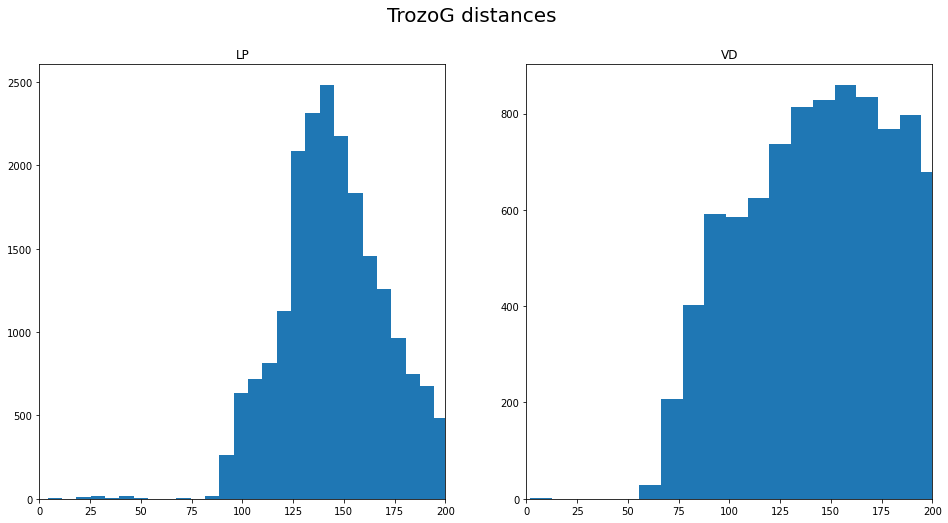

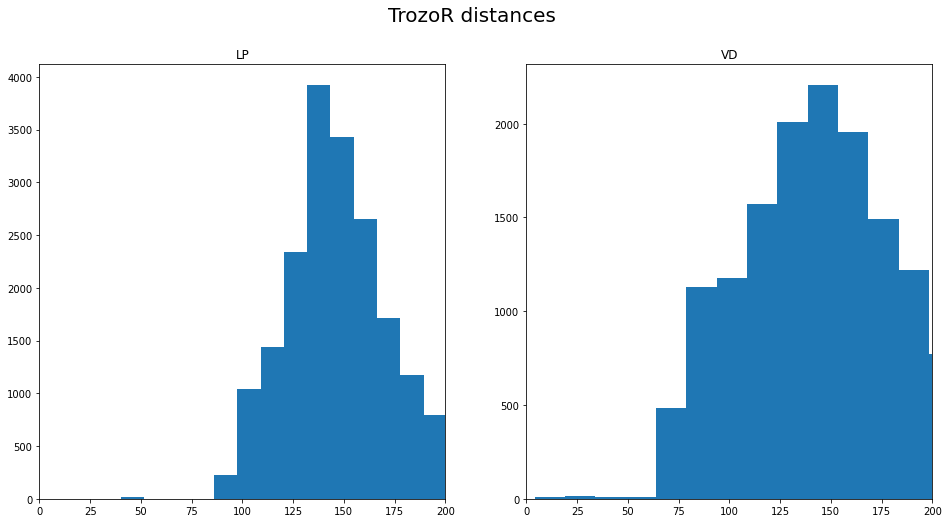

In [8]:
def distances_b_events(name, lp_events, vd_events, lmin,lmax):
    """
        show distance between spikes distribution
        Args:
            name (str): name of chunk to analyze
            lp_events (numpy): index of lp spikes found
            vd_events (numpy): index of vd spikes found
            lmin (int): lower limit of plot
            lmax (int): upper limit of plot

    """
        
    lp_distances = np.diff(lp_events)
    vd_distances = np.diff(vd_events)
    
    print("________________ {0} ________________".format(name))
    print("________ LP ________")
    print('Min: {0}'.format(np.amin(lp_distances)))
    print('Max: {0}'.format(np.amax(lp_distances)))
    print('Mean: {0}'.format(np.mean(lp_distances)))
    print('Medium: {0}'.format(np.median(lp_distances)))
    print('Q1: {0}'.format(np.quantile(lp_distances, 0.00025)))
    print("________ VD ________")
    print('Min: {0}'.format(np.amin(vd_distances)))
    print('Max: {0}'.format(np.amax(vd_distances)))
    print('Mean: {0}'.format(np.mean(vd_distances)))
    print('Medium: {0}'.format(np.median(vd_distances)))
    print('Q1: {0}'.format(np.quantile(vd_distances, 0.00025)))
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16, 8)
    fig.suptitle('{0} distances'.format(name), fontsize=20)

    ax1.hist(lp_distances, bins=2000)
    ax1.set_xlim((lmin, lmax))
    ax1.set_title("LP")

    ax2.hist(vd_distances, bins=2000)
    ax2.set_title("VD")
    ax2.set_xlim((lmin, lmax))

distances_b_events('TrozoC', lp_spikes_C, vd_spikes_C, 0, 200)
distances_b_events('TrozoG', lp_spikes_G, vd_spikes_G, 0, 200)
distances_b_events('TrozoR', lp_spikes_R, vd_spikes_R, 0, 200)

La mayor distancia mínima encontrada es igual a 40 para la neurona LP en la etapa de recuperación y la menor distancia mínima encontrada entre spikes es igual a 2 para la neurona VD en la etapa de inyección de GABA. Este último valor es muy sospechoso, sobre todo teniendo en cuenta que utilizamos registros con un desfase temporal igual a 0.1. Para lidiar con el posible ruido en los datos y que no perjudique nuestro análisis de transmisión de información, se realiza un análisis de las distancias mínimas entre spikes cuando forzamos distintas distancias entre spikes en la detección de los mismos. 

In [9]:
distances = [1,2,3,4,5,6,7,8,9,10,11,12]
for distance in distances:
    c_lp = np.amin(np.diff(find_peaks(trozoC.LP, thresholdC[0], distance = distance)[0]))
    c_vd = np.amin(np.diff(find_peaks(trozoC.VD, thresholdC[1], distance = distance)[0]))

    g_lp = np.amin(np.diff(find_peaks(trozoG.LP, thresholdG[0], distance = distance)[0]))
    g_vd = np.amin(np.diff(find_peaks(trozoG.VD, thresholdG[1], distance = distance)[0]))

    r_lp = np.amin(np.diff(find_peaks(trozoR.LP, thresholdR[0], distance = distance)[0]))
    r_vd = np.amin(np.diff(find_peaks(trozoR.VD, thresholdR[1], distance = distance)[0]))
    
    print(f'Min distance between spikes with distance forced to {distance} = {min(c_lp,c_vd,g_lp,g_vd,r_lp,r_vd)}')

Min distance between spikes with distance forced to 1 = 2
Min distance between spikes with distance forced to 2 = 2
Min distance between spikes with distance forced to 3 = 3
Min distance between spikes with distance forced to 4 = 4
Min distance between spikes with distance forced to 5 = 5
Min distance between spikes with distance forced to 6 = 8
Min distance between spikes with distance forced to 7 = 8
Min distance between spikes with distance forced to 8 = 8
Min distance between spikes with distance forced to 9 = 9
Min distance between spikes with distance forced to 10 = 10
Min distance between spikes with distance forced to 11 = 16
Min distance between spikes with distance forced to 12 = 16


Vemos que cuando forzamos una distancia entre spikes entre 6 y 8, la distancia mínima entre spikes es igual a 8, lo que nos garantiza realizar un análisis de transmisión de información entre neuronas utilizando palabras de hasta 8 bits. Por tanto, para maximizar el tamaño de la ventana, hemos decidido utilizar una distancia entre spikes mínima igual a 8 a la hora de detectarlos.

A continuación se calculan el número total de spikes por neurona en cada etapa así como las nuevas distancias entre spikes bajo las nuevas restricciones.

________________ TrozoC ________________
Total events (LP): 31226
Total events (VD): 22333
________________ TrozoG ________________
Total events (LP): 26630
Total events (VD): 15661
________________ TrozoR ________________
Total events (LP): 24961
Total events (VD): 18672


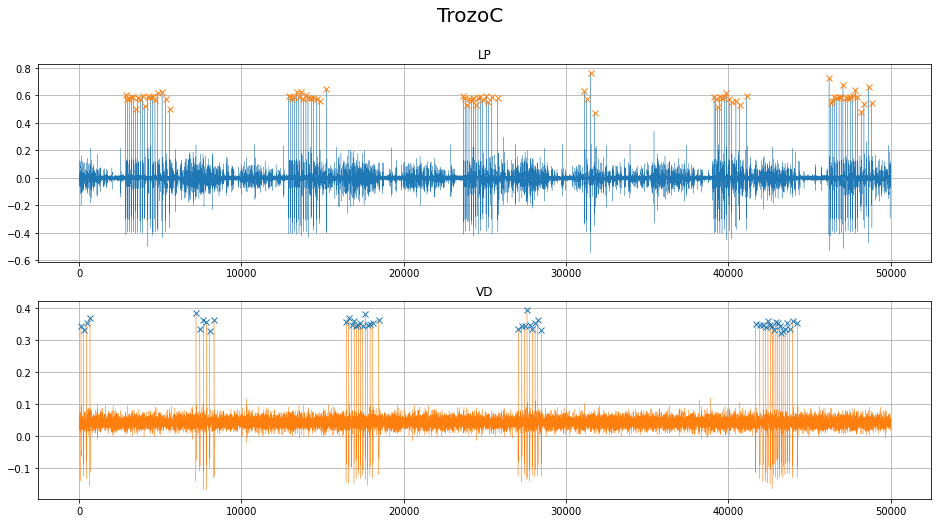

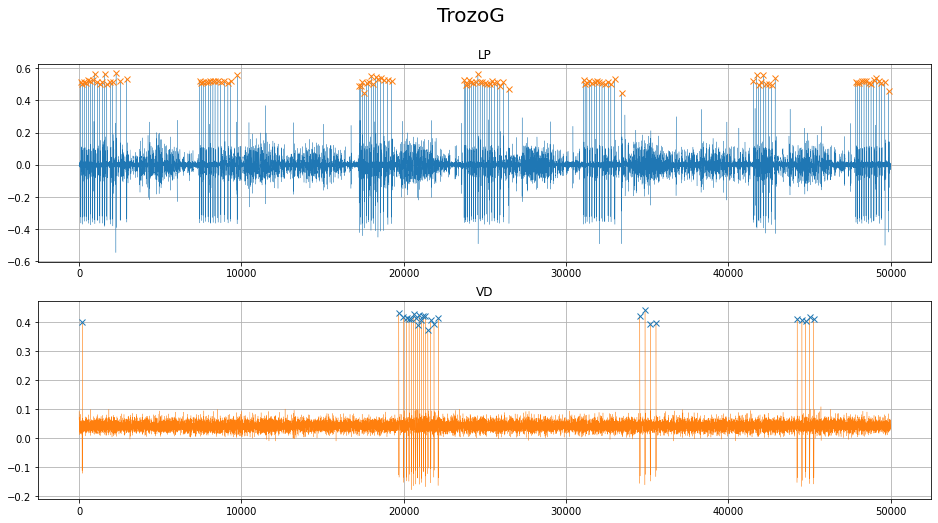

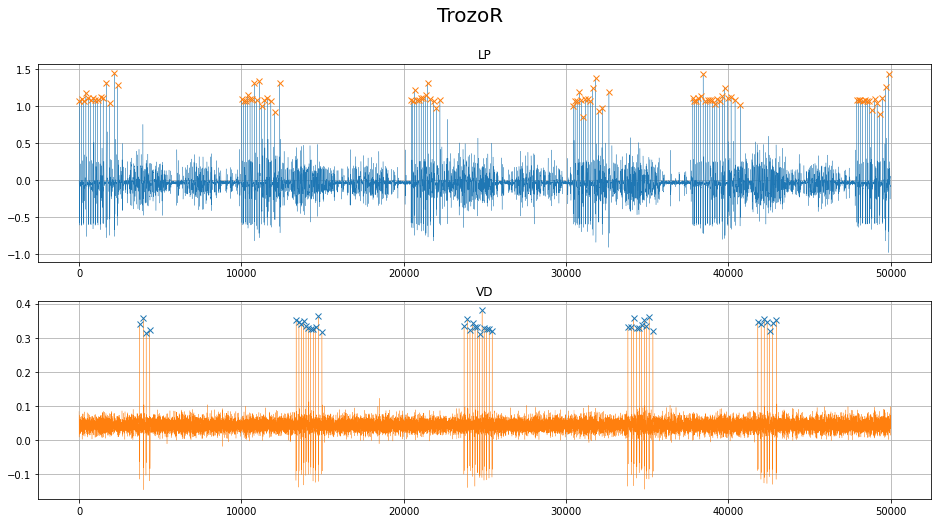

In [9]:
lp_spikes_C, vd_spikes_C = find_events(trozoC, 'TrozoC', thresholdC, 8)
lp_spikes_G, vd_spikes_G = find_events(trozoG, 'TrozoG', thresholdG, 8)
lp_spikes_R, vd_spikes_R = find_events(trozoR, 'TrozoR', thresholdR, 8)

________________ TrozoC ________________
________ LP ________
Min: 24
Max: 22323
Mean: 635.4512409927943
Medium: 154.0
Q1: 26.0
________ VD ________
Min: 8
Max: 29910
Mean: 888.457907934802
Medium: 160.0
Q1: 18.0
________________ TrozoG ________________
________ LP ________
Min: 20
Max: 14121
Mean: 614.973262232904
Medium: 155.0
Q1: 25.0
________ VD ________
Min: 60
Max: 21409
Mean: 1045.8955300127714
Medium: 191.0
Q1: 63.0
________________ TrozoR ________________
________ LP ________
Min: 40
Max: 23023
Mean: 656.3359375
Medium: 155.0
Q1: 41.23975
________ VD ________
Min: 8
Max: 29910
Mean: 877.3076428686198
Medium: 159.0
Q1: 18.0


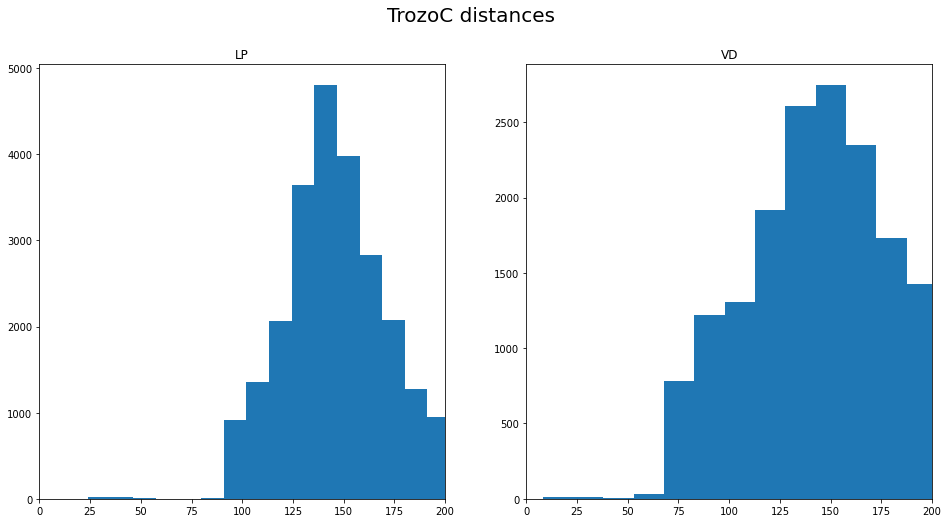

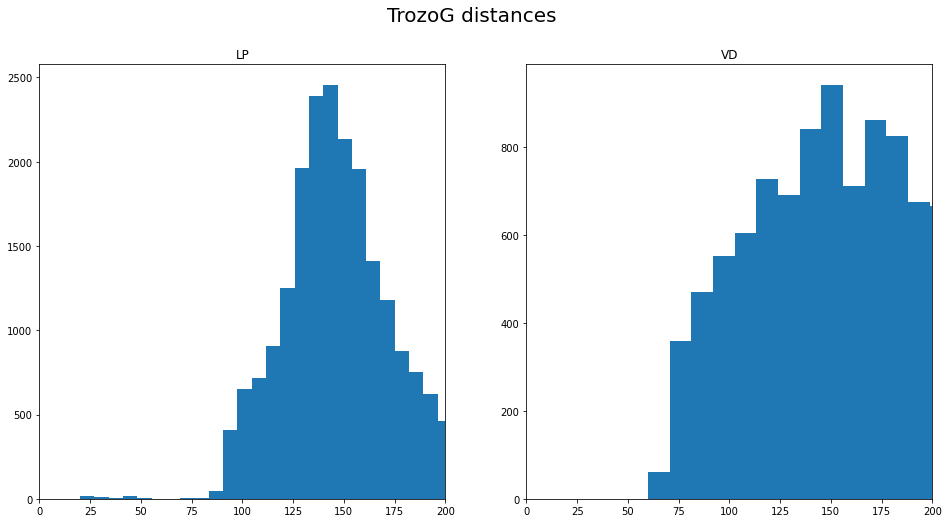

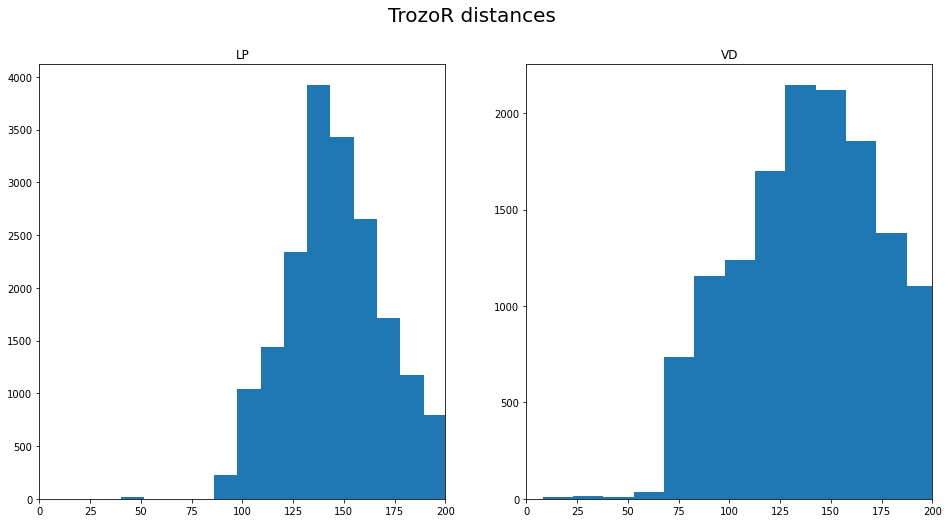

In [10]:
distances_b_events('TrozoC', lp_spikes_C, vd_spikes_C, 0, 200)
distances_b_events('TrozoG', lp_spikes_G, vd_spikes_G, 0, 200)
distances_b_events('TrozoR', lp_spikes_R, vd_spikes_R, 0, 200)

### 2.3. Discretización

Una vez bien definidos los eventos de nuestro análisis procedemos a discretizar las señales utilizando una codificación binaria, de modo que se asignará una valor igual a 1 aquellos valores de la señal clasificados como spikes y un valor de 0 para el resto de valores. De esta manera, las señales de las neuronas LP y VD de cada etapa también pueden considerarse como una muestra de una variable aleatoria de Bernoulli.


Se ilustra la nueva codificación de la señal.

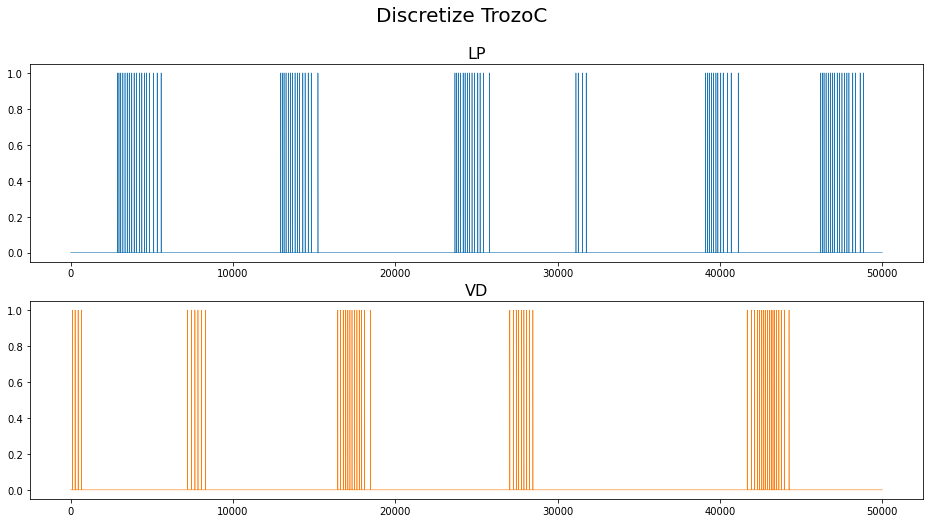

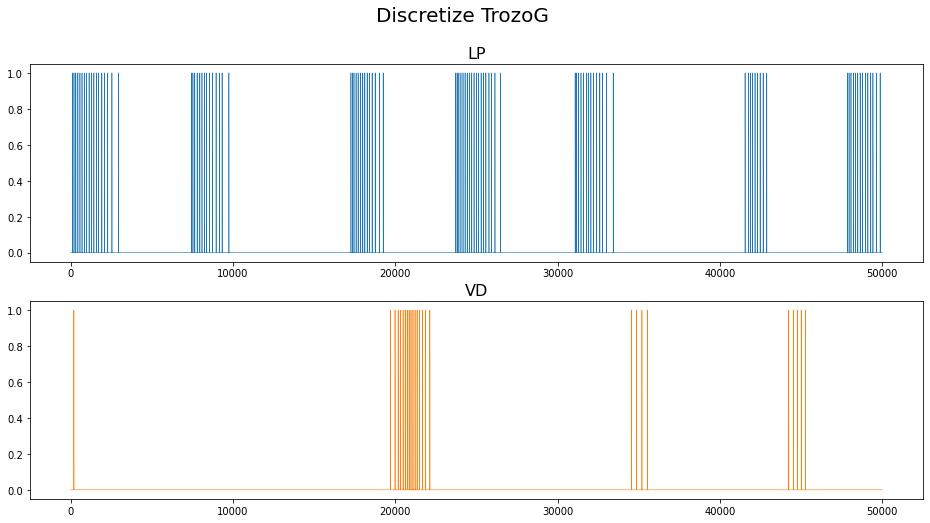

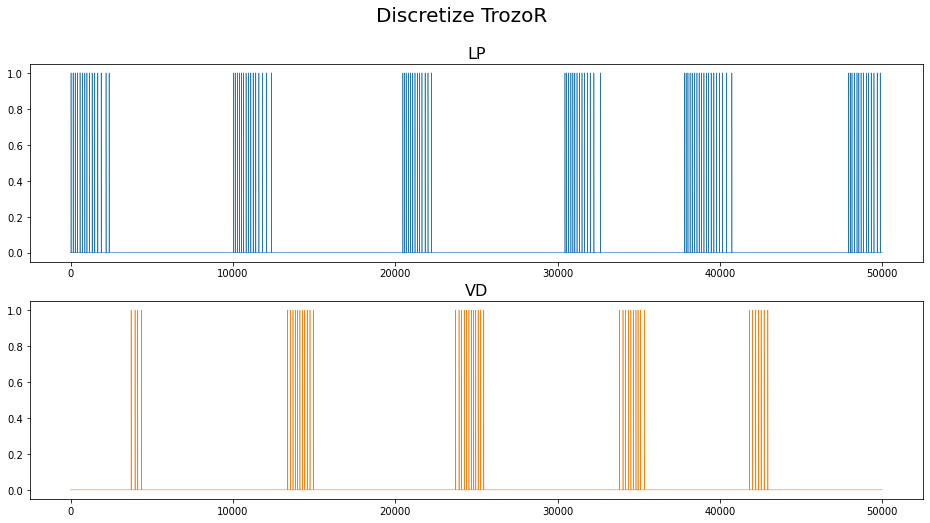

In [11]:
def discretize_by_speaks(chunk, lp_spikes, vd_spikes):
    """
        Binary encoding for spikes (spike = 1, other = 0)
        Args:
            chunk (Dataframe): chunk to analyze
            lp_spikes (numpy): index of lp spikes found
            vd_spikes (numpy): index of vd spikes found

    """

    chunk['LP_spikes'] = 0
    chunk.loc[lp_spikes, 'LP_spikes'] = 1
    chunk['VD_spikes'] = 0
    chunk.loc[vd_spikes, 'VD_spikes'] = 1
    return chunk

def show_discretize_spikes(chunk, coding, name, n):
    """
        Show the first n binary encoding for spikes (spike = 1, other = 0)
        Args:
            chunk (Dataframe): chunk to analyze
            coding (str): kind of events
            name (str): name of chunk to analyze
            n (int): n records to show

    """
    
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_size_inches(16, 8)
    plt.suptitle('Discretize {0}'.format(name), fontsize=20)
    ax1.plot(chunk[f'LP_{coding}'].iloc[:n],lw=0.6)
    ax1.set_title("LP", fontsize=16)
    ax2.plot(chunk[f'VD_{coding}'].iloc[:n],'tab:orange',lw=0.6)
    ax2.set_title("VD", fontsize=16)


trozoC = discretize_by_speaks(trozoC, lp_spikes_C, vd_spikes_C)
show_discretize_spikes(trozoC, 'spikes', 'TrozoC', 50000)

trozoG = discretize_by_speaks(trozoG, lp_spikes_G, vd_spikes_G)
show_discretize_spikes(trozoG, 'spikes', 'TrozoG', 50000)

trozoR = discretize_by_speaks(trozoR, lp_spikes_R, vd_spikes_R)
show_discretize_spikes(trozoR, 'spikes', 'TrozoR', 50000)

### 2.4. Tamaño de ventana

En la codificación anterior, asumíamos un tamaño de ventana fijo igual a 1. Sin embargo, nos interesa maximizar el tamaño de la ventana de modo que no se obtenga más de un spike en la ventana. Con este objetivo en mente, calcularemos la tasa de error al variar el tamaño de la ventana.

Para tamaños de ventana fijos, en todas las etapas, las neuronas LP y VD comienzan a presentar un mayor número de errores, i.e, presentan más de un spike por ventana, cuando se utilizan tamaños aproximadamente superiores a 100. 

In [12]:
def get_errors_rate(signal, bin_size):
    """
        Get error rate for a signal varying the bin size
        Args:
            signal (numpy): signal to analyze
            bin_size ([int]): array with bin sizes to calculate error rate
    """

    errors_rate = []
    for nbin in bin_size:
        bins_spikes = view_as_windows(signal, window_shape=nbin, step=nbin).sum(axis=1)
        errors_rate.append((bins_spikes>1).sum()/len(bins_spikes))
    return np.array(errors_rate)

def get_errors_rate_per_neuron(chunk, coding, name, bin_size):
    """
        Get error rate for each signal LP and VD varying the bin size
        Args:
            chunk (Dataframe): chunk to analyze
            coding (str): kind of events
            name (str): name of chunk to analyze
            bin_size ([int]): array with bin sizes to calculate error rate
    """
    lp_errors = get_errors_rate(np.array(chunk[f'LP_{coding}']),bin_size)
    vd_errors = get_errors_rate(np.array(chunk[f'VD_{coding}']),bin_size)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    fig.set_size_inches(16, 8)
    plt.suptitle('Error rate per bin size ({0})'.format(name), fontsize=20)
    ax1.plot(bin_size, lp_errors)
    ax1.set_title("LP", fontsize=16)
    ax2.plot(bin_size, vd_errors)
    ax2.set_title("VD", fontsize=16)
    
    return lp_errors, vd_errors

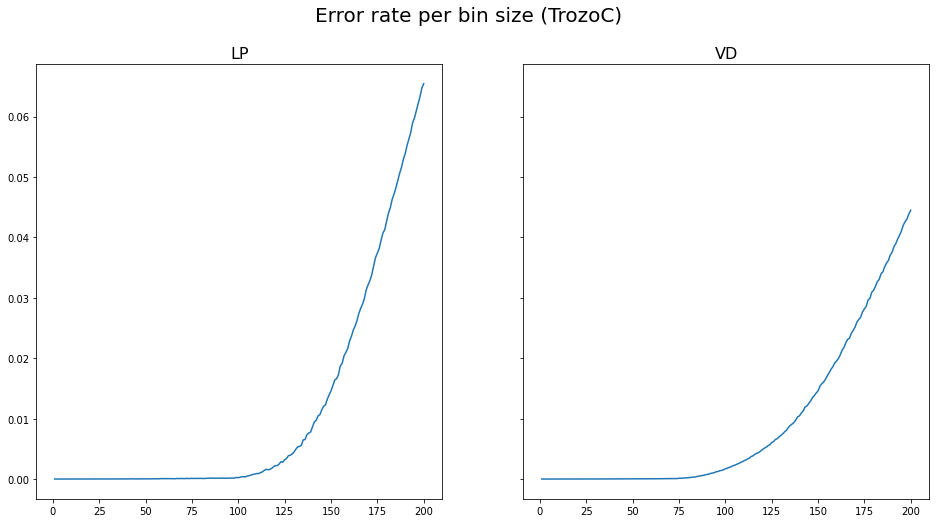

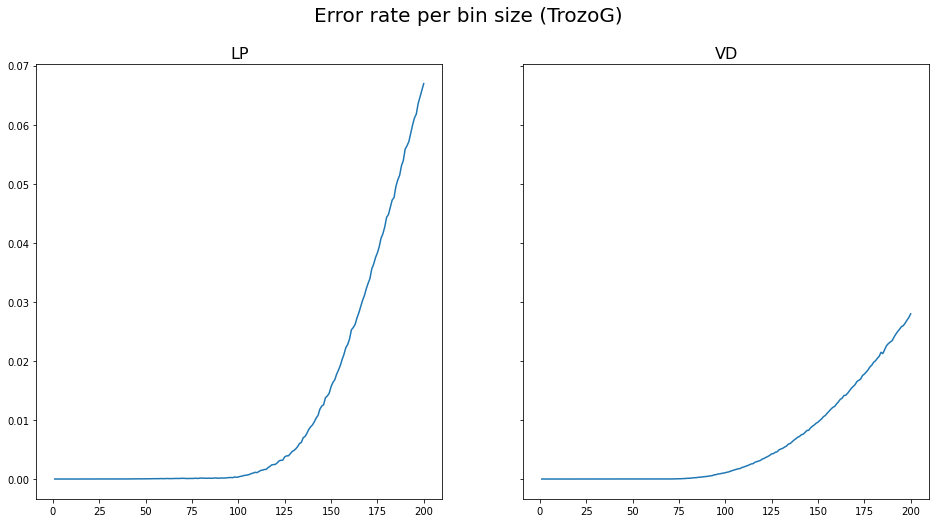

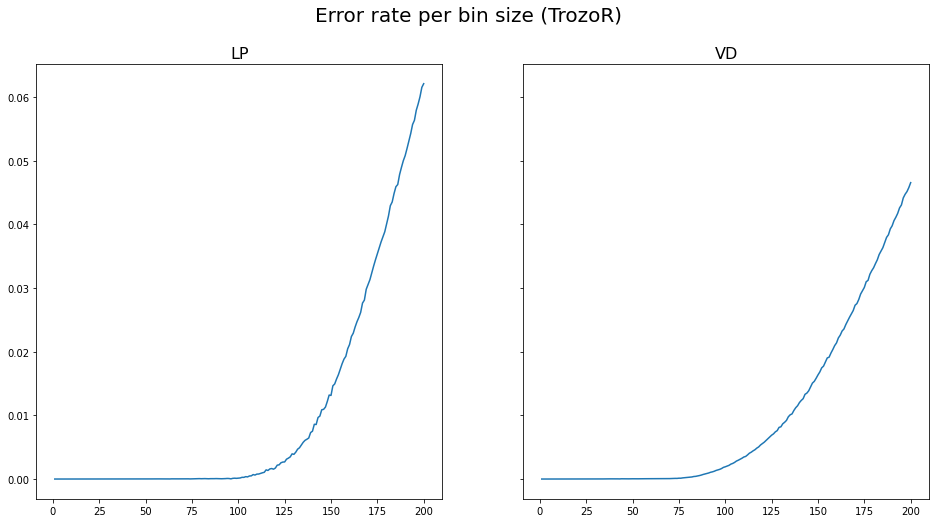

In [34]:
def get_errors_rate(signal, bin_size):
    """
        Get error rate for a signal varying the bin size
        Args:
            signal (numpy): signal to analyze
            bin_size ([int]): array with bin sizes to calculate error rate
    """

    errors_rate = []
    for nbin in bin_size:
        bins_spikes = view_as_windows(signal, window_shape=nbin, step=nbin).sum(axis=1)
        errors_rate.append((bins_spikes>1).sum()/len(bins_spikes))
    return np.array(errors_rate)

def get_errors_rate_per_neuron(chunk, coding, name, bin_size):
    """
        Get error rate for each signal LP and VD varying the bin size
        Args:
            chunk (Dataframe): chunk to analyze
            coding (str): kind of events
            name (str): name of chunk to analyze
            bin_size ([int]): array with bin sizes to calculate error rate
    """
    lp_errors = get_errors_rate(np.array(chunk[f'LP_{coding}']),bin_size)
    vd_errors = get_errors_rate(np.array(chunk[f'VD_{coding}']),bin_size)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    fig.set_size_inches(16, 8)
    plt.suptitle('Error rate per bin size ({0})'.format(name), fontsize=20)
    ax1.plot(bin_size, lp_errors)
    ax1.set_title("LP", fontsize=16)
    ax2.plot(bin_size, vd_errors)
    ax2.set_title("VD", fontsize=16)
    
    return lp_errors, vd_errors

lp_errors_C, vd_errors_C = get_errors_rate_per_neuron(trozoC, 'spikes', 'TrozoC', range(1,201))
lp_errors_G, vd_errors_G = get_errors_rate_per_neuron(trozoG, 'spikes', 'TrozoG', range(1,201))
lp_errors_R, vd_errors_R = get_errors_rate_per_neuron(trozoR, 'spikes', 'TrozoR', range(1,201))

## 3. Cálculo de la entropía y la información mutua


El objetivo final del análisis de las señales en las distintas etapas es estudiar la transmisión de información entre las neuronas LP y VD. Para ello realizaremos una segunda codificación que consiste en la suma de los spikes por ventana para los distintos tamaños de ventana. Esto supone trabajar con una muestra de una variable aleatoria Binomial. 

Primero implementaremos una serie de funciones que permitan realizar esta segunda codificación, así como convertir la información en palabras de distintos bits. En segundo lugar se implementarán las funciones necesarias para calcular la entropía y la información mutua de las señales a partir del cálculo de sus probabilidades individuales y conjuntas.

Antes de continuar con la implementación de las funciones comentadas arriba, recordemos las características de cada una de las medidas de información que utilizaremos en el análisis: **<añadir formulas>**

Para optimizar estos cálculos, la estrategia llevada acabo en esta práctica consiste en trabajar con *Diccionarios*, de manera que se definirá un diccionario para cada neurona con la siguiente estructura:
```
{   
    "1": {"mi": # Mutual Information for each bin size, 
            "elp": # LP entropy for each bin size, 
            "evd": # VD entropy for each bin size, 
            "ti_lp_vd": # LP-->VD transmission for each bin size, 
            "ti_vd_lp": # VD-->LP transmission for each bin size
           },
    "2": {...}
}
```
Las claves del diccionario serán el tamaño de palabra utilizado y cada tamaño de palabra contendrá un diccionario con las medidas de información más importantes para cada tamaño de ventana.

In [16]:
def to_words(signal, nbits, nsteps):
    """

    """
    
    if nbits == 1:
        return np.array(list(map(str,signal)))
    else:
        signal_bin = view_as_windows(np.array(signal), window_shape=nbits, step=nsteps)
        return np.array([''.join(map(str,bins)) for bins in signal_bin])

def prob(x): # x : np of str (words)
    """

    """
    
    keys, counts = np.unique(x, return_counts=True)
    return dict(zip(keys,counts/len(x)))

def joint_prob(x, y):  # x,y : np of str (words)
    """

    """
    
    xy = list(map('|'.join,zip(x, y)))
    keys, counts = np.unique(xy, return_counts=True)
    return dict(zip(keys,counts/len(x)))

def entropy(x): # x : dict of probabilities
    """

    """
    
    return - np.sum([w * np.log2(w) for w in x.values()])
    
def MI(x, y): # x,y : np of str (words)
    """

    """
    
    px, py, pxy = prob(x),prob(y),joint_prob(x,y)
    ex, ey = entropy(px), entropy(py)
    mi=0
    for k in pxy:
        kx, ky = k.split('|')
        mi += pxy[k] * np.log2(pxy[k]/(px[kx] * py[ky]))
    return mi, ex, ey

In [17]:
def show_probabilities(chunk, coding, nbits, name):
    """

    """
    
    print("________________ {0} ________________".format(name))
    lp_words = to_words(chunk[f'LP_{coding}'], nbits, nbits)
    vd_words = to_words(chunk[f'VD_{coding}'], nbits, nbits)
    prob_lp,prob_vd = prob(lp_words),prob(vd_words)
    joint_prob_lpvd = joint_prob(lp_words,vd_words)
    mi, e_clp, e_cvd = MI(lp_words,vd_words)
    print("Probabilidades LP con {0} bit: \n{1}".format(nbits, json.dumps(prob_lp,sort_keys=True, indent=2)))
    print("\nProbabilidades VD con {0} bit: \n{1}".format(nbits, json.dumps(prob_vd,sort_keys=True, indent=2)))
    print("\nProbabilidades Conjuntas LP y VD con {0} bit: \n{1}".format(nbits, json.dumps(joint_prob_lpvd,sort_keys=True, indent=2)))
    print("\nEntropía LP con {0} bit: {1}".format(nbits, e_clp))
    print("\nEntropía VD con {0} bit: {1}".format(nbits, e_cvd))
    print("\nInformación Mutua LP y VD con {0} bit: {1}".format(nbits, mi))

Ejemplo de la información obtenida para las señales LP y VD de Control utilizando un tamaño de ventana igual a 1, y un tamaño de palabra igual a 2.

In [18]:
show_probabilities(chunk = trozoC, coding = 'spikes', nbits = 2, name = 'TrozoC')

#[show_probabilities(i, trozoC, 'TrozoC') for i in [1,2,8]]
#[show_probabilities(i, trozoG, 'TrozoG') for i in [1,2,8]]
#[show_probabilities(i, trozoR, 'TrozoR') for i in [1,2,8]]

________________ TrozoC ________________
Probabilidades LP con 2 bit: 
{
  "00": 0.9968534389375091,
  "01": 0.001570862115005769,
  "10": 0.001575698947485099
}

Probabilidades VD con 2 bit: 
{
  "00": 0.9977495629216484,
  "01": 0.0011249666208175255,
  "10": 0.0011254704575341223
}

Probabilidades Conjuntas LP y VD con 2 bit: 
{
  "00|00": 0.9946032033938441,
  "00|01": 0.0011247650861308867,
  "00|10": 0.0011254704575341223,
  "01|00": 0.0015707613476624496,
  "01|01": 1.0076734331937706e-07,
  "10|00": 0.0015755981801417796,
  "10|01": 1.0076734331937706e-07
}

Entropía LP con 2 bit: 0.03383317609372063

Entropía VD con 2 bit: 0.025287372660367055

Información Mutua LP y VD con 2 bit: 9.118029643424215e-06


In [19]:
def compute_signal_by_bins(bin_size, chunk, coding):
    """
    
    """
    
    lp_bins, vd_bins = {}, {}
    for nbins in bin_size:
        lp_bins[nbins] = view_as_windows(np.array(chunk[f'LP_{coding}']), window_shape=nbins, step=nbins).sum(axis=1)
        vd_bins[nbins] = view_as_windows(np.array(chunk[f'VD_{coding}']), window_shape=nbins, step=nbins).sum(axis=1)
    
    return lp_bins, vd_bins

def compute_information(word_size, bin_size, lp_bins, vd_bins, fix):
    """
    
    """
    information = {}
    for nbits in word_size:
        mi_l, elp_l, evd_l = [], [], []
        for nbins in bin_size:
            if fix == True:
                lp_words = to_words(lp_bins[nbins], nbits, nbits)
                vd_words = to_words(vd_bins[nbins], nbits, nbits)
            else:
                lp_words = to_words(lp_bins[nbins], nbits, 1)
                vd_words = to_words(vd_bins[nbins], nbits, 1)
            m_i, e_lp, e_vd = MI(lp_words,vd_words)
            mi_l.append(m_i)
            elp_l.append(e_lp)
            evd_l.append(e_vd)
        information[nbits] = {'mi': np.array(mi_l),'elp': np.array(elp_l),'evd': np.array(evd_l), 'ti_lp_vd':np.array(mi_l)/np.array(elp_l), 'ti_vd_lp':np.array(mi_l)/np.array(evd_l)}
    return information

In [20]:
bin_size = range(1,151)
lp_bins_C, vd_bins_C = compute_signal_by_bins(bin_size, chunk = trozoC, coding = 'spikes')
lp_bins_G, vd_bins_G = compute_signal_by_bins(bin_size, chunk = trozoG, coding = 'spikes')
lp_bins_R, vd_bins_R = compute_signal_by_bins(bin_size, chunk = trozoR, coding = 'spikes')

### Palabras fijas

In [21]:
word_size = range(1,9)
information_C = compute_information(word_size, bin_size, lp_bins_C, vd_bins_C, True)
information_G = compute_information(word_size, bin_size, lp_bins_G, vd_bins_G, True)
information_R = compute_information(word_size, bin_size, lp_bins_R, vd_bins_R, True)

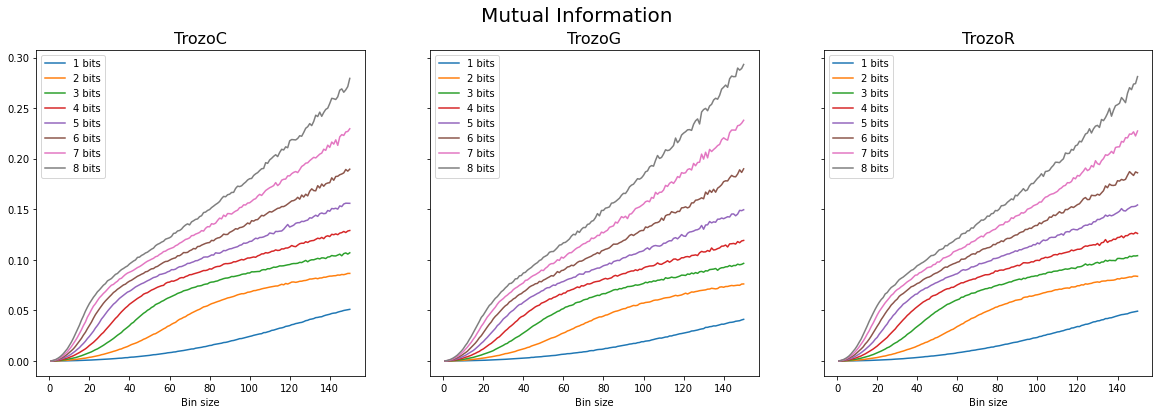

In [22]:
def plot_mutual_information(information_C, information_G, information_R, word_size, bin_size):
    """
    
    """

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    fig.set_size_inches(20, 6)
    plt.suptitle(f'Mutual Information', fontsize=20)
    

    for nbits in word_size:
        ax1.plot(bin_size, information_C[nbits]['mi'], label = f"{nbits} bits")
    ax1.set_title("TrozoC", fontsize=16)
    ax1.set_xlabel("Bin size")
    ax1.legend()

    for nbits in word_size:
        ax2.plot(bin_size, information_G[nbits]['mi'], label = f"{nbits} bits")
    ax2.set_title("TrozoG", fontsize=16)
    ax2.set_xlabel("Bin size")
    ax2.legend()

    for nbits in word_size:
        ax3.plot(bin_size, information_R[nbits]['mi'], label = f"{nbits} bits")
    ax3.set_title("TrozoR", fontsize=16)
    ax3.set_xlabel("Bin size")
    ax3.legend()
    
    plt.show()
    
plot_mutual_information(information_C, information_G, information_R, word_size, bin_size)

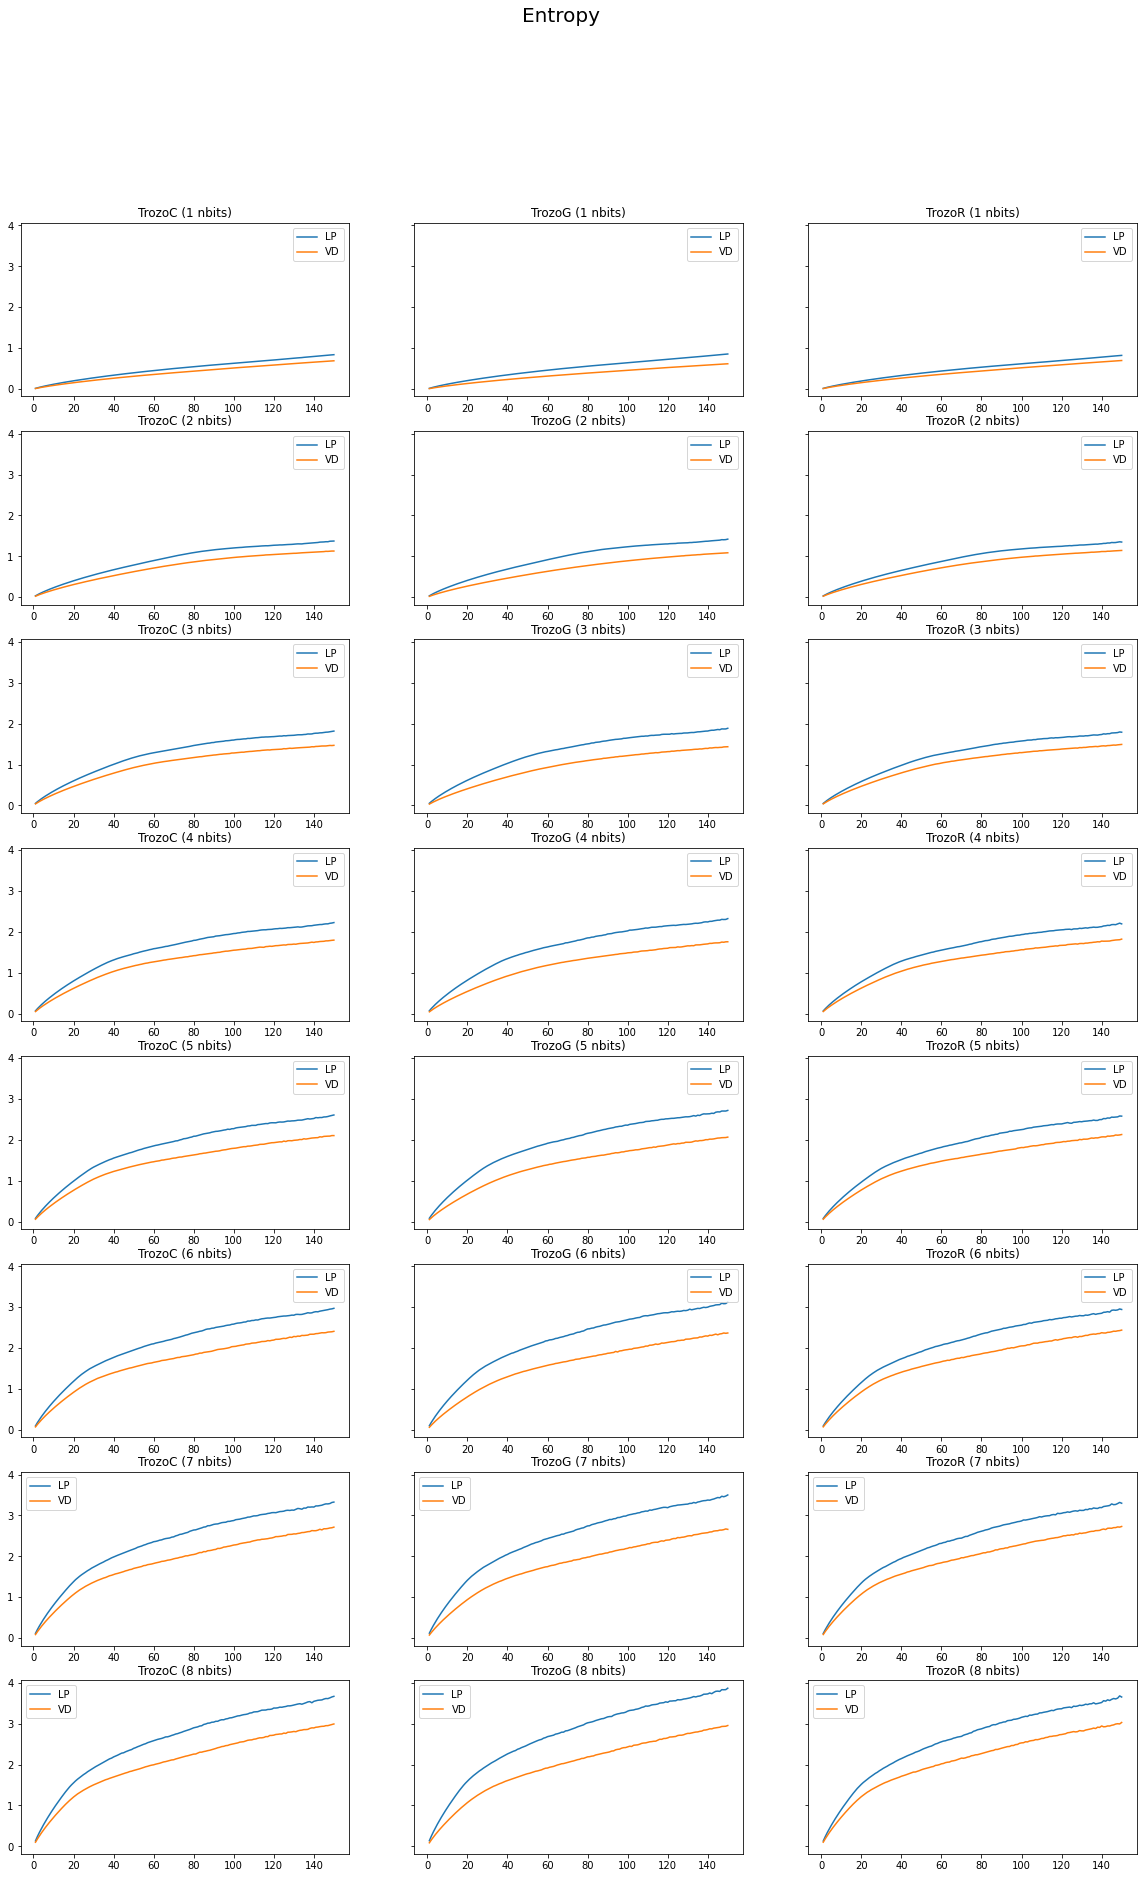

In [23]:
def plot_entropia(informationC,informationG,informationR, word_size, bin_size):
    """
    
    """
    fig, axes = plt.subplots(len(word_size), 3, figsize=(20, 30), sharey=True)
    plt.suptitle(f'Entropy', fontsize=20)
    for nbits,row in enumerate(axes):
        row[0].plot(bin_size,informationC[nbits+1]['elp'],label='LP')
        row[0].plot(bin_size,informationC[nbits+1]['evd'],label='VD')
        row[0].set_title(f"TrozoC ({nbits+1} nbits)")
        row[0].legend()

        row[1].plot(bin_size,informationG[nbits+1]['elp'],label='LP')
        row[1].plot(bin_size,informationG[nbits+1]['evd'],label='VD')
        row[1].set_title(f"TrozoG ({nbits+1} nbits)")
        row[1].legend()

        row[2].plot(bin_size,informationR[nbits+1]['elp'],label='LP')
        row[2].plot(bin_size,informationR[nbits+1]['evd'],label='VD')
        row[2].set_title(f"TrozoR ({nbits+1} nbits)")
        row[2].legend()

    plt.show()
    
plot_entropia(information_C, information_G, information_R, word_size, bin_size)

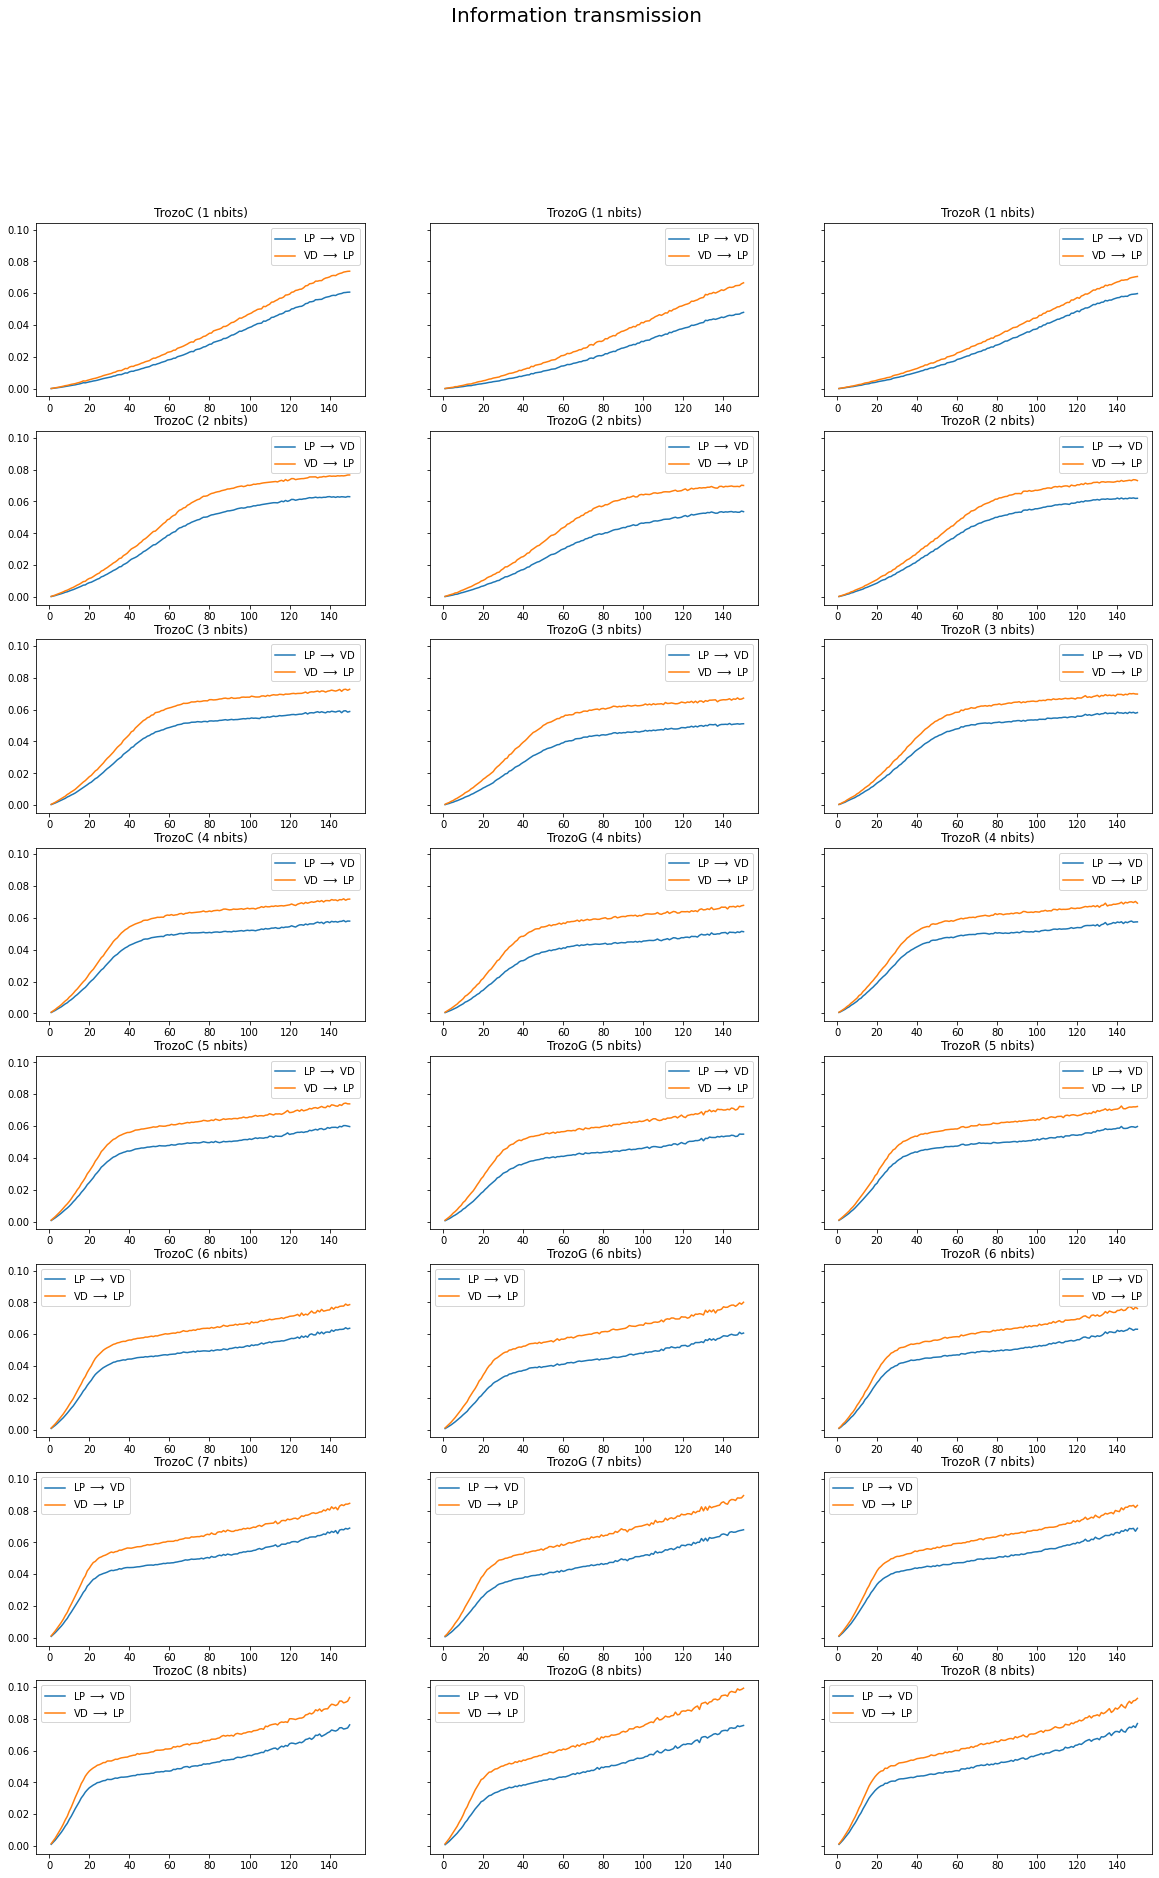

In [24]:
def plot_transfer_info(informationC,informationG,informationR, word_size, bin_size):
    fig, axes = plt.subplots(len(word_size), 3, figsize=(20, 30), sharey=True)
    plt.suptitle(f'Information transmission', fontsize=20)
    for nbits,row in enumerate(axes):
        row[0].plot(bin_size,informationC[nbits+1]['ti_lp_vd'],label=r'LP $\longrightarrow$ VD')
        row[0].plot(bin_size,informationC[nbits+1]['ti_vd_lp'],label=r'VD $\longrightarrow$ LP')
        row[0].set_title(f"TrozoC ({nbits+1} nbits)")
        row[0].legend()

        row[1].plot(bin_size,informationG[nbits+1]['ti_lp_vd'],label=r'LP $\longrightarrow$ VD')
        row[1].plot(bin_size,informationG[nbits+1]['ti_vd_lp'],label=r'VD $\longrightarrow$ LP')
        row[1].set_title(f"TrozoG ({nbits+1} nbits)")
        row[1].legend()

        row[2].plot(bin_size,informationR[nbits+1]['ti_lp_vd'],label=r'LP $\longrightarrow$ VD')
        row[2].plot(bin_size,informationR[nbits+1]['ti_vd_lp'],label=r'VD $\longrightarrow$ LP')
        row[2].set_title(f"TrozoR ({nbits+1} nbits)")
        row[2].legend()

    plt.show()
    
plot_transfer_info(information_C, information_G, information_R, word_size, bin_size)

### Palabras solapadas

In [25]:
word_size = range(1,9)
information_C = compute_information(word_size, bin_size, lp_bins_C, vd_bins_C, False)

In [26]:
len(information_C)

8

In [27]:
information_G = compute_information(word_size, bin_size, lp_bins_G, vd_bins_G, False)

In [28]:
information_R = compute_information(word_size, bin_size, lp_bins_R, vd_bins_R, False)

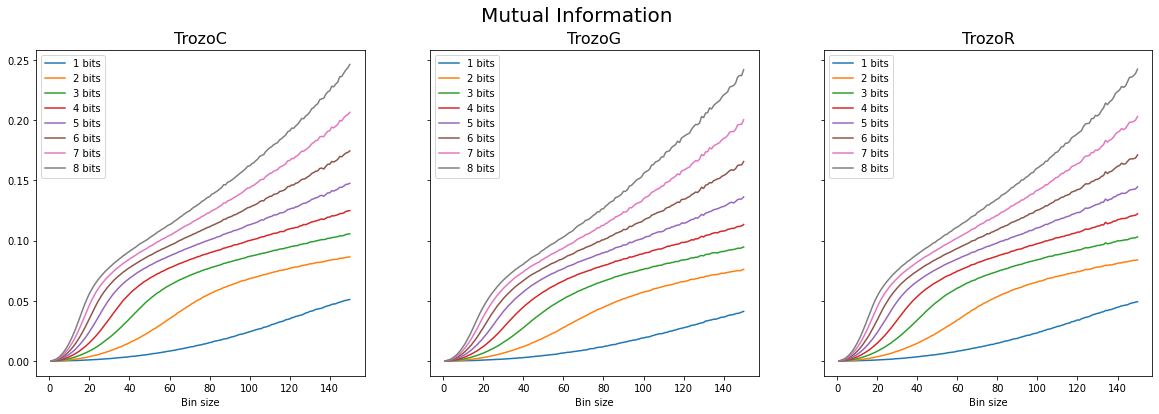

In [29]:
plot_mutual_information(information_C, information_G, information_R, word_size, bin_size)

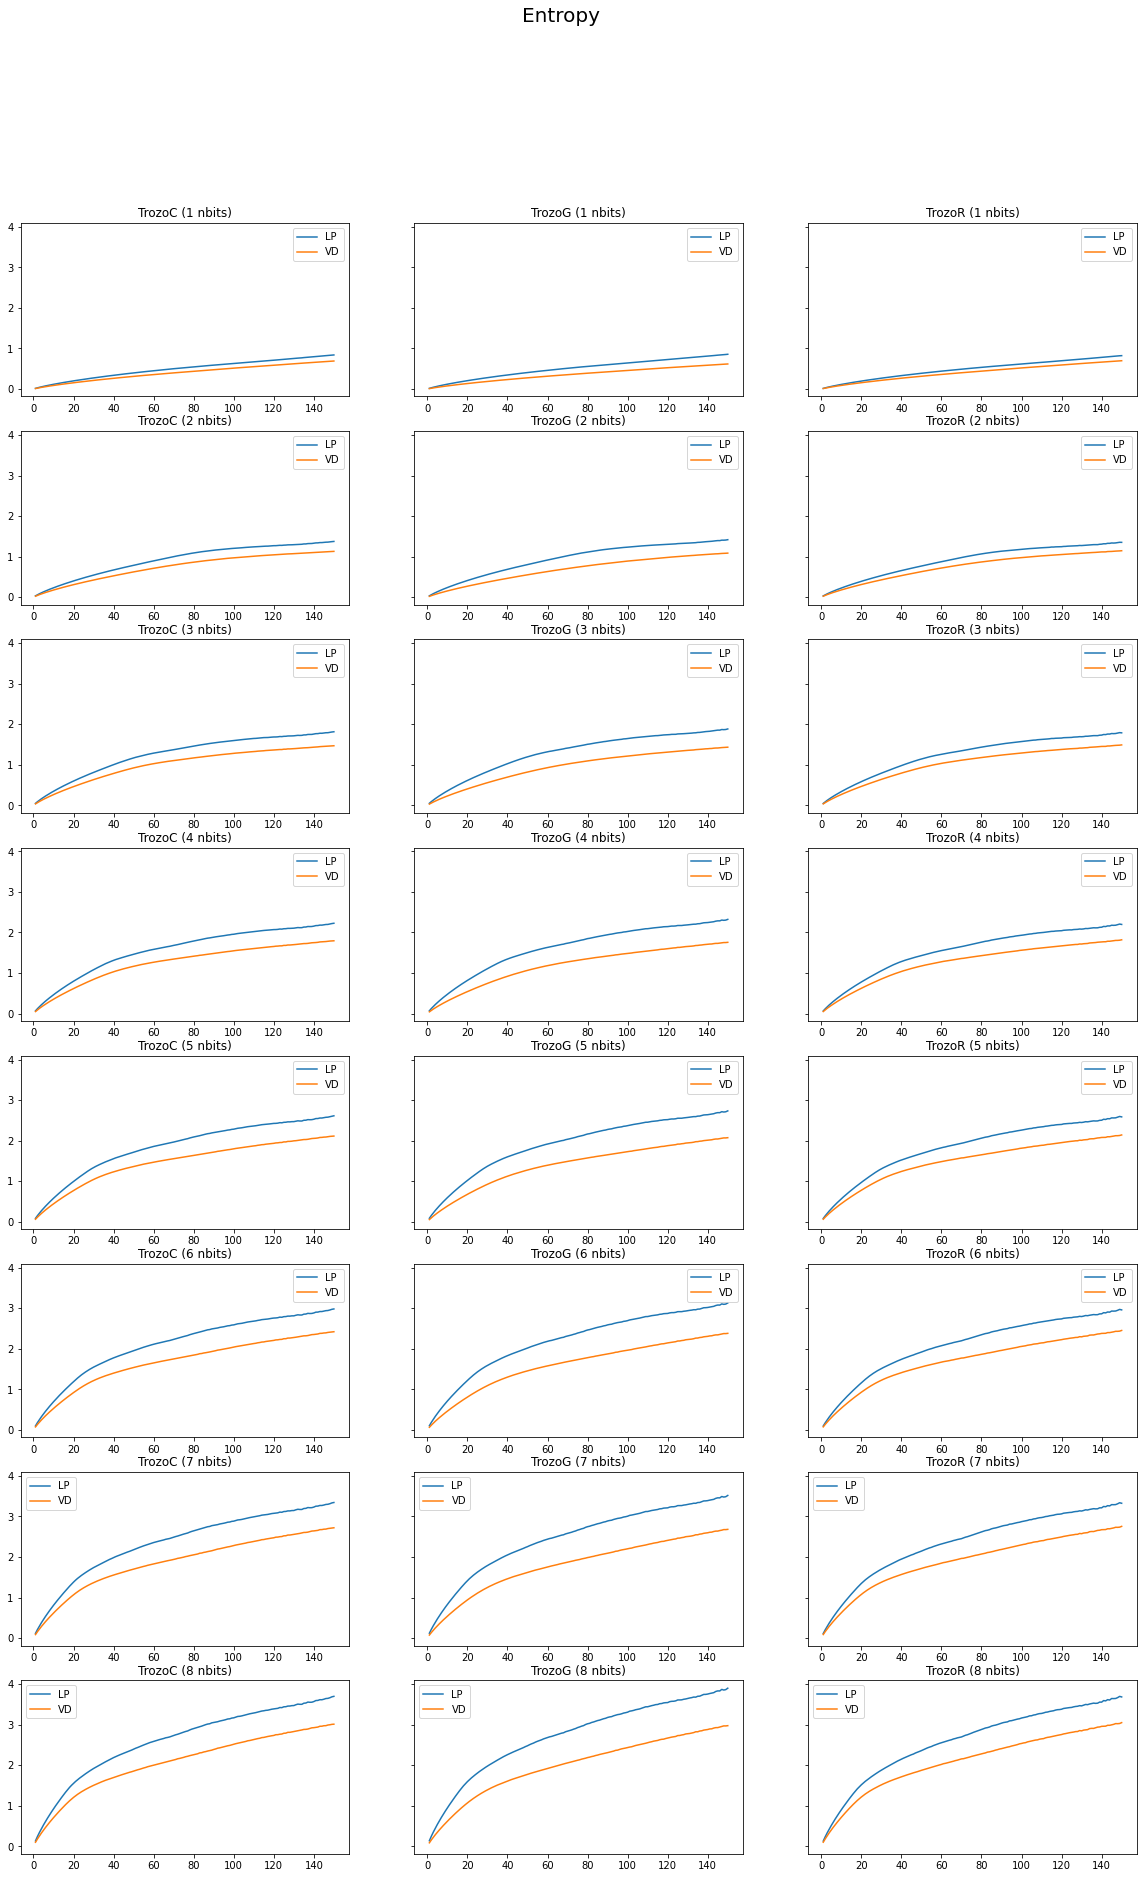

In [30]:
plot_entropia(information_C, information_G, information_R, word_size, bin_size)

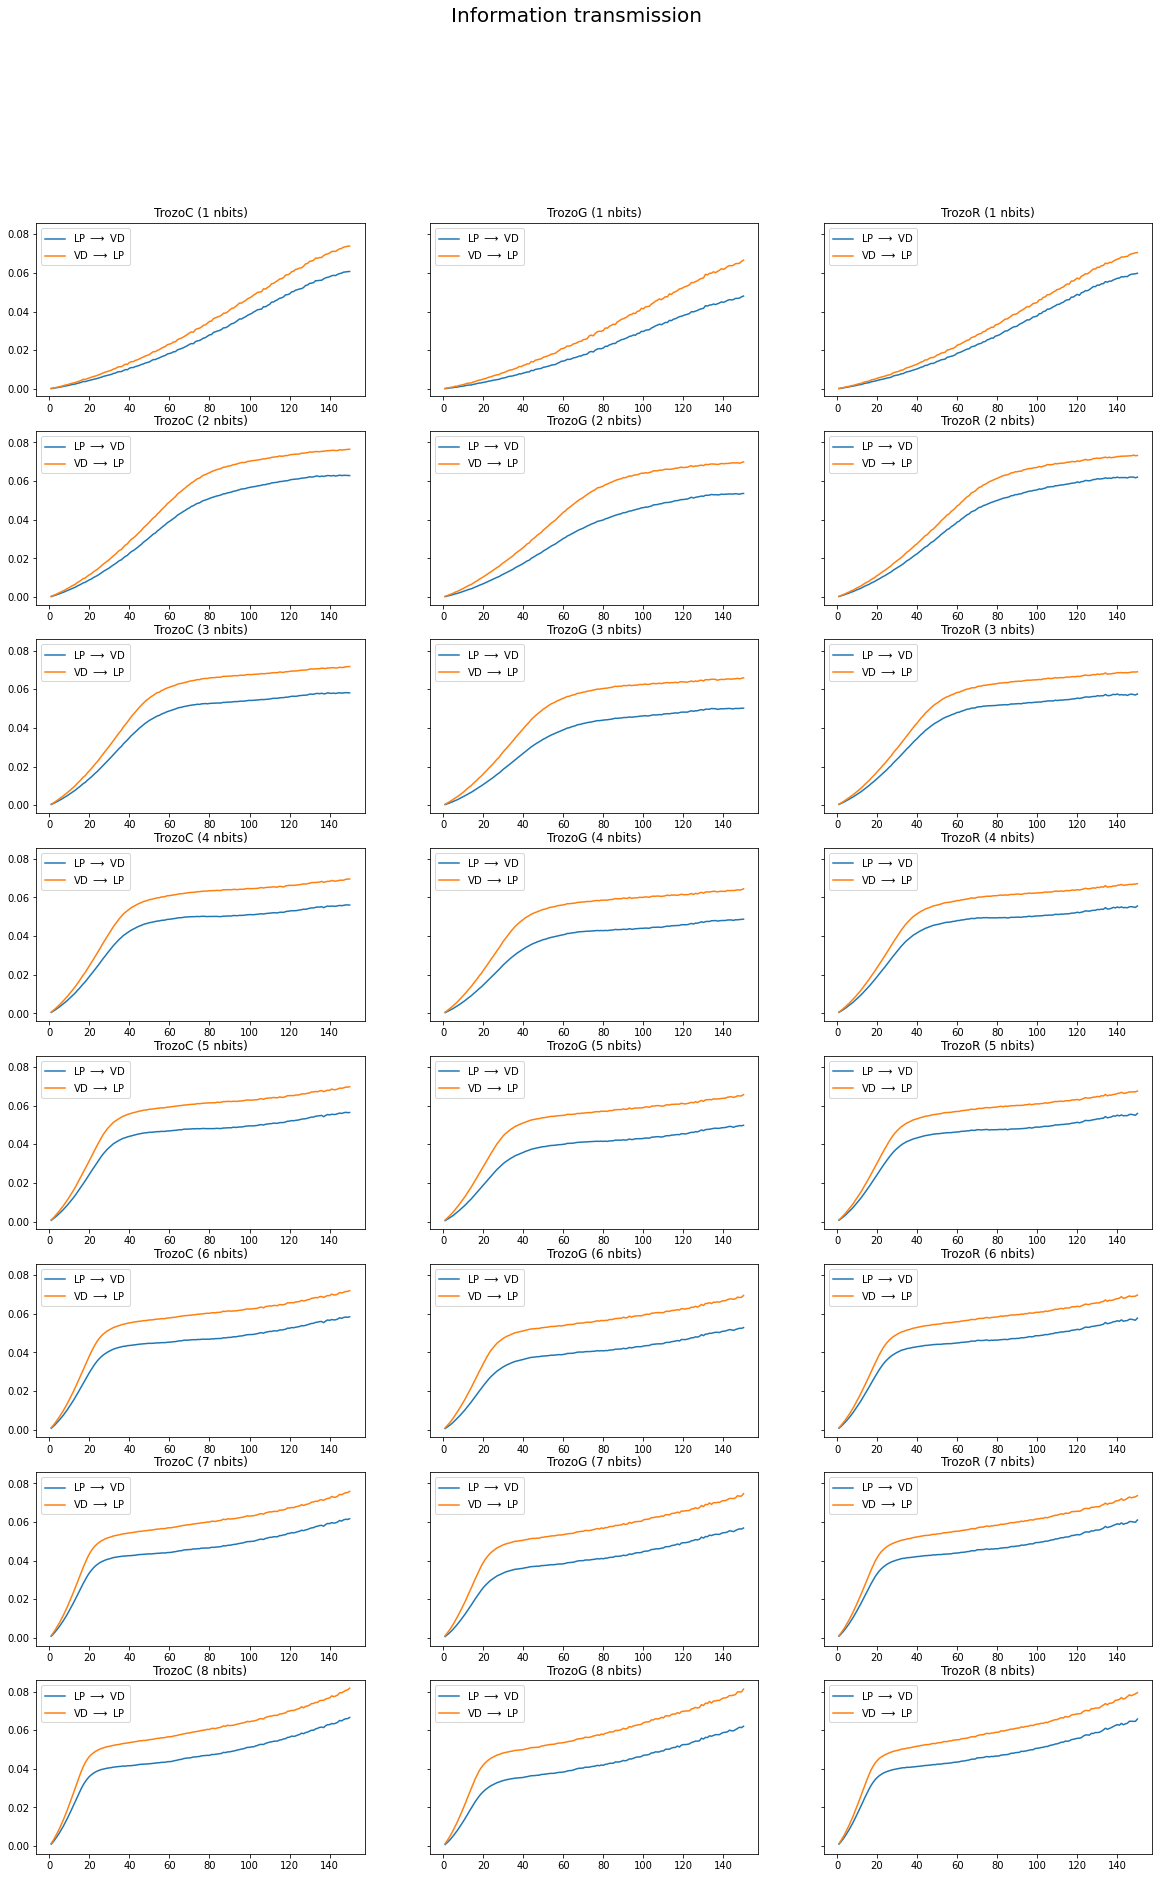

In [31]:
plot_transfer_info(information_C, information_G, information_R, word_size, bin_size)

# Cambio de codificación: Bursts

En lugar de utilizar los spikes como eventos a analizar, en esta nueva codificación vamos a utilizar bursts, que son agrupaciones de spikes cercanos en el tiempo. De esta manera, los eventos de interés serán sucesiones de spikes.


________________ TrozoC ________________
Total events (LP): 2460
Total events (VD): 2105
________________ TrozoG ________________
Total events (LP): 2295
Total events (VD): 1934
________________ TrozoR ________________
Total events (LP): 2036
Total events (VD): 1738


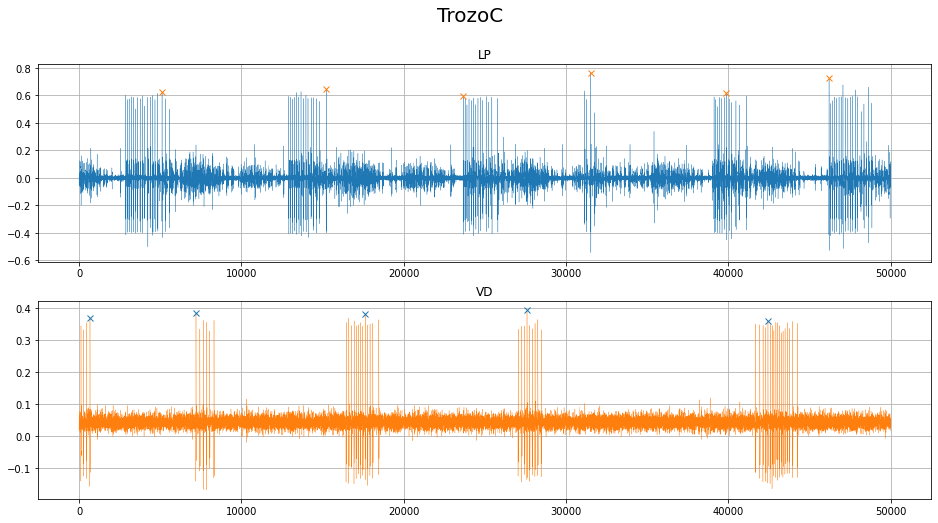

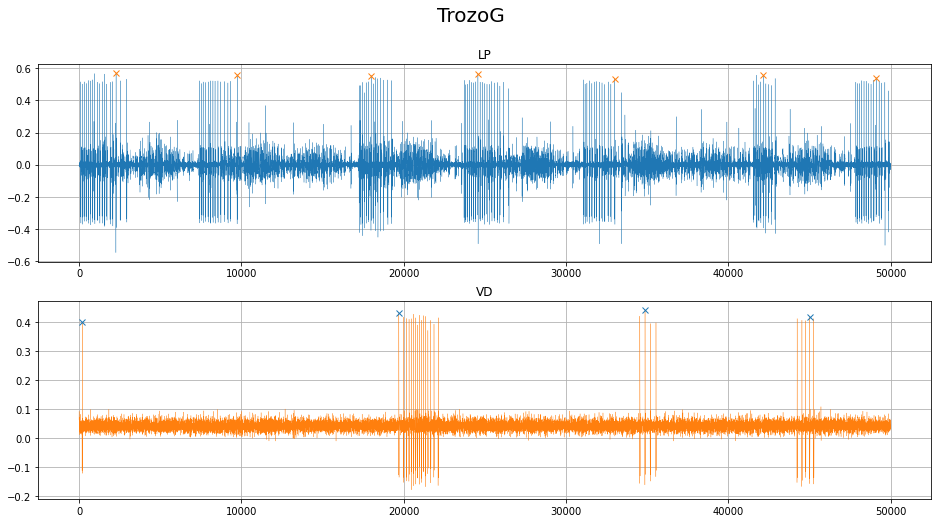

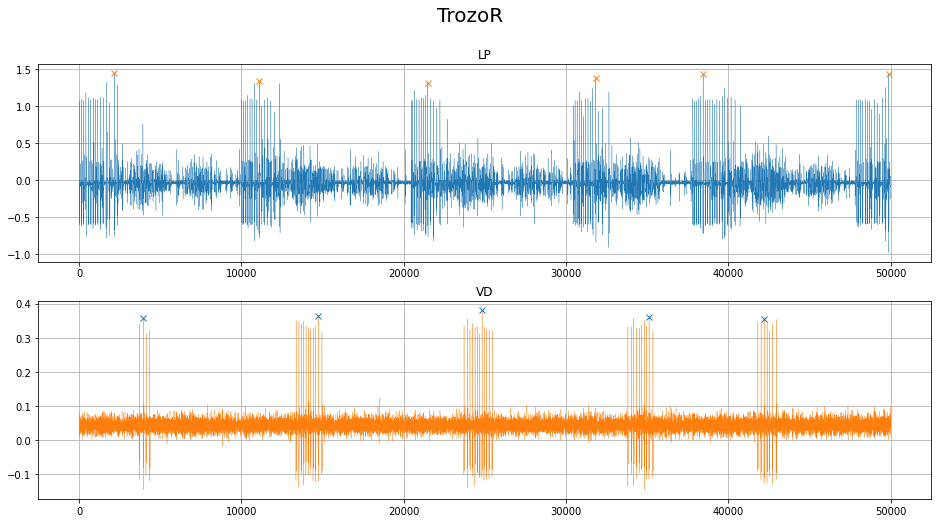

In [13]:
lp_bursts_C, vd_bursts_C = find_events(trozoC,'TrozoC', thresholdC, 3000)
lp_bursts_G, vd_bursts_G = find_events(trozoG,'TrozoG', thresholdG, 3000)
lp_bursts_R, vd_bursts_R = find_events(trozoR,'TrozoR', thresholdR, 3000)

________________ TrozoC ________________
________ LP ________
Min: 3003
Max: 25385
Mean: 8048.514987714988
Medium: 8007.0
Q1: 3003.5085
________ VD ________
Min: 3000
Max: 32748
Mean: 9429.185836501902
Medium: 9125.5
Q1: 3000.52575
________________ TrozoG ________________
________ LP ________
Min: 3005
Max: 16114
Mean: 7137.610723626853
Medium: 7015.0
Q1: 3014.74525
________ VD ________
Min: 3010
Max: 23574
Mean: 8472.562338334195
Medium: 8002.0
Q1: 3010.966
________________ TrozoR ________________
________ LP ________
Min: 3003
Max: 25385
Mean: 8048.514987714988
Medium: 8007.0
Q1: 3003.5085
________ VD ________
Min: 3000
Max: 32748
Mean: 9429.727691421991
Medium: 9102.0
Q1: 3000.434


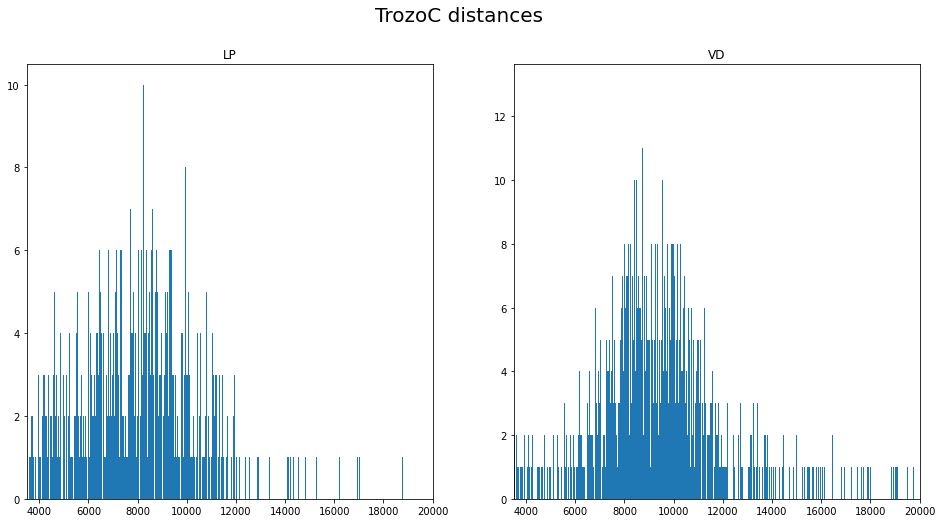

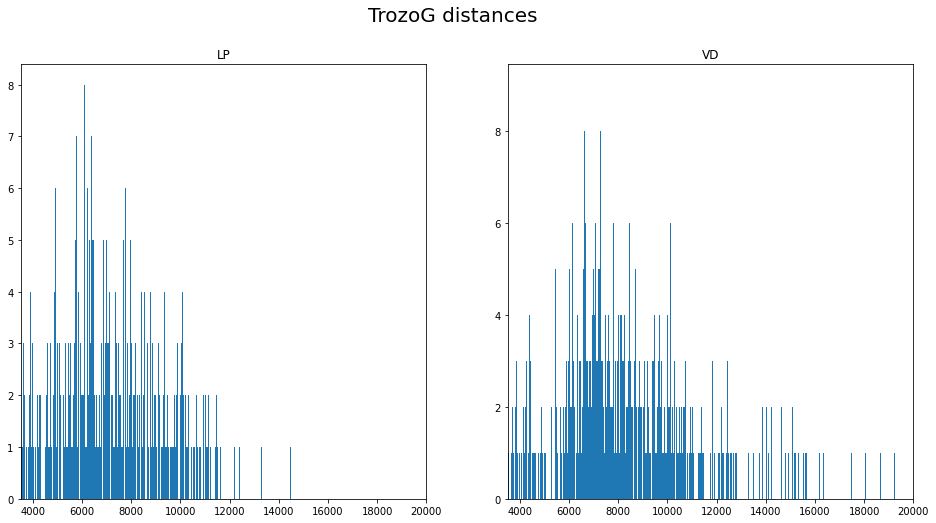

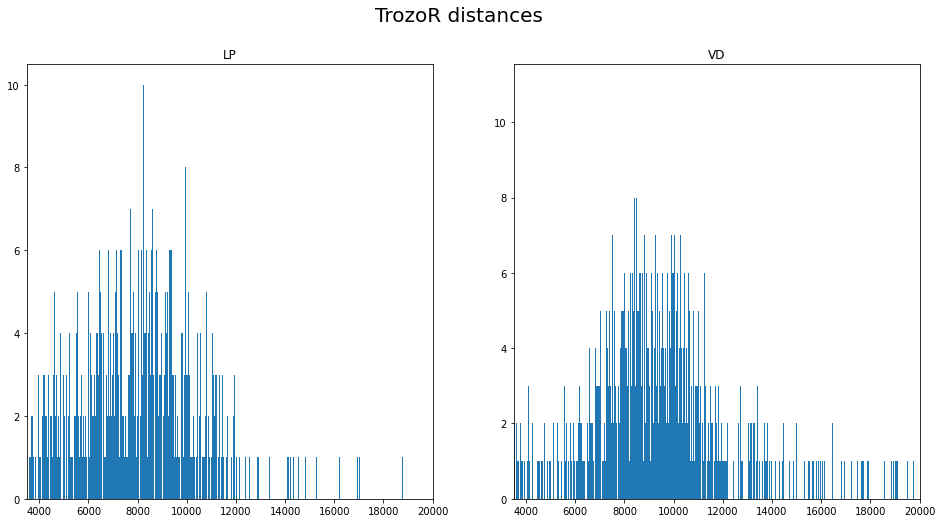

In [14]:
distances_b_events('TrozoC', lp_bursts_R, vd_bursts_C, 3500, 20000)
distances_b_events('TrozoG', lp_bursts_G, vd_bursts_G, 3500, 20000)
distances_b_events('TrozoR', lp_bursts_R, vd_bursts_R, 3500, 20000)

In [15]:
def show_discretize_burst(chunk, coding, name, n):
    """
    
    """
    
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_size_inches(16, 8)
    plt.suptitle('Discretize {0}'.format(name), fontsize=20)
    ax1.plot(chunk[f'LP_{coding}'].iloc[:n],lw=0.6, label = 'LP')
    ax1.plot(chunk[f'VD_{coding}'].iloc[:n],'tab:orange',lw=0.6, label='VD')
    
    ax2.plot(chunk[f'LP'].iloc[:n],lw=0.6, label = 'LP')
    ax2.plot(chunk[f'VD'].iloc[:n],'tab:orange',lw=0.6, label='VD')


def discretize_by_bursts(chunk, lp_bursts, vd_bursts):
    """
    
    """

    chunk['LP_bursts'] = 0
    chunk.loc[lp_bursts, 'LP_bursts'] = 1
    chunk['VD_bursts'] = 0
    chunk.loc[vd_bursts, 'VD_bursts'] = 1
    return chunk

In [16]:
trozoC = discretize_by_bursts(trozoC, lp_bursts_C, vd_bursts_C)
trozoG = discretize_by_bursts(trozoG, lp_bursts_G, vd_bursts_G)
trozoR = discretize_by_bursts(trozoR, lp_bursts_R, vd_bursts_R)

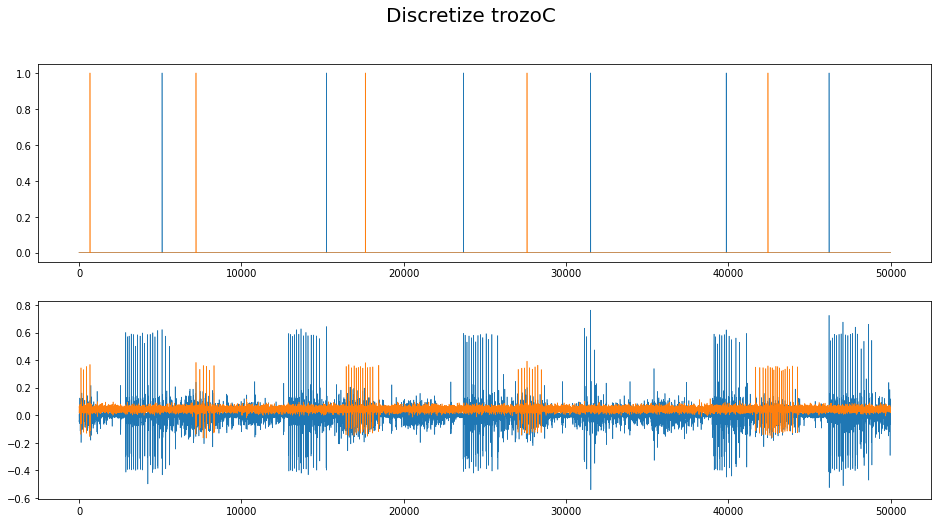

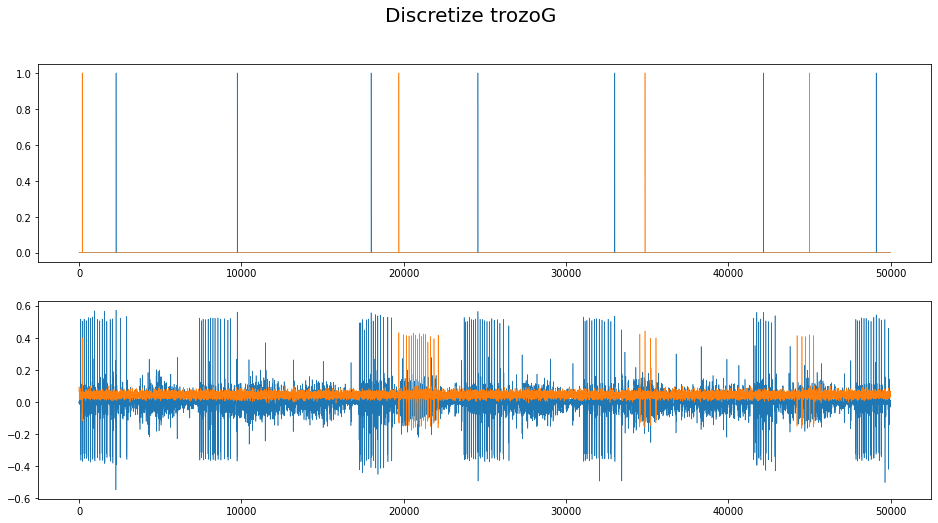

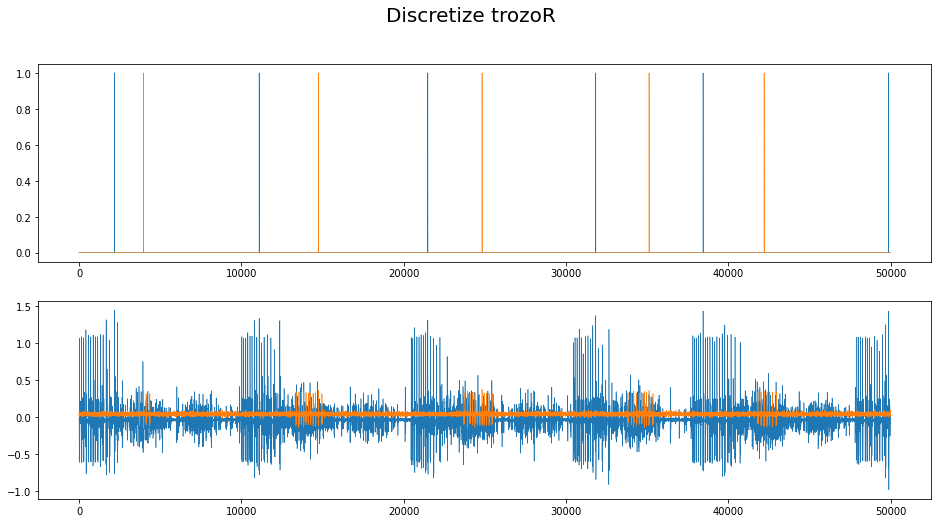

In [17]:
show_discretize_burst(trozoC, 'bursts', 'trozoC', 50000)
show_discretize_burst(trozoG, 'bursts', 'trozoG', 50000)
show_discretize_burst(trozoR, 'bursts', 'trozoR', 50000)

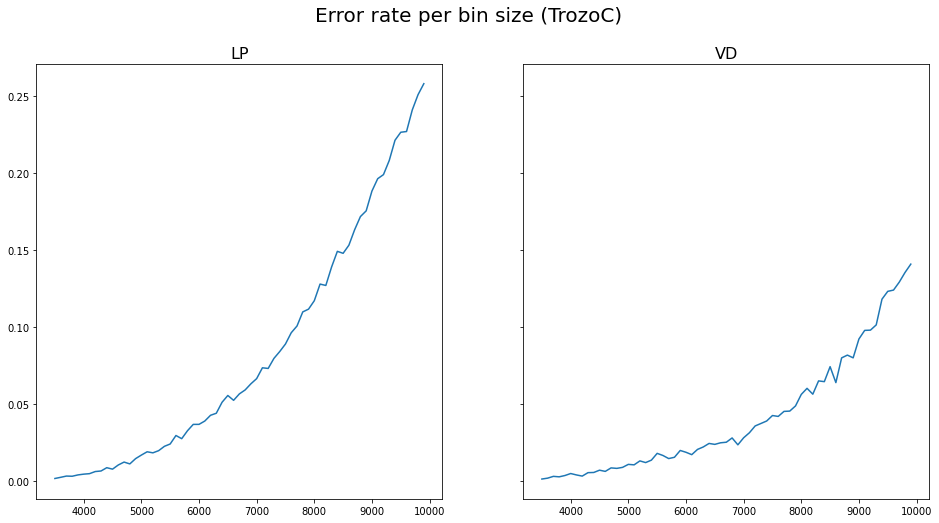

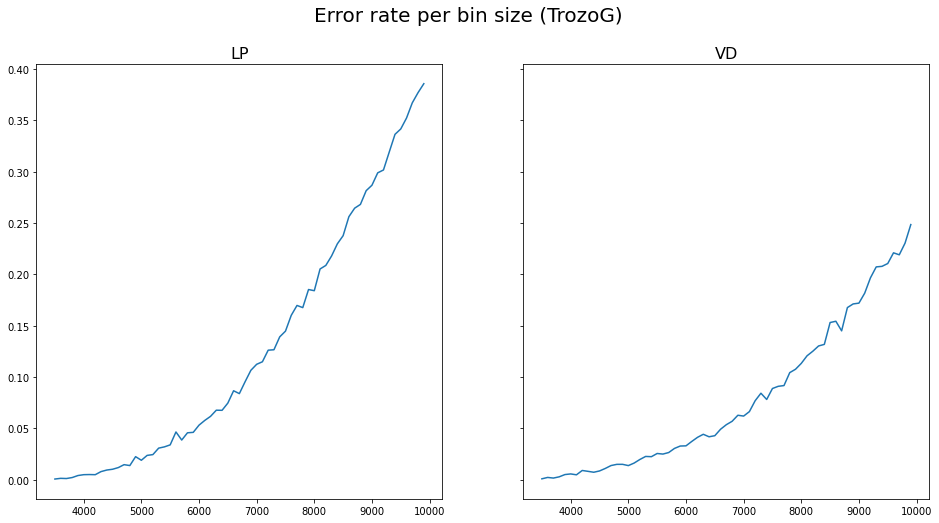

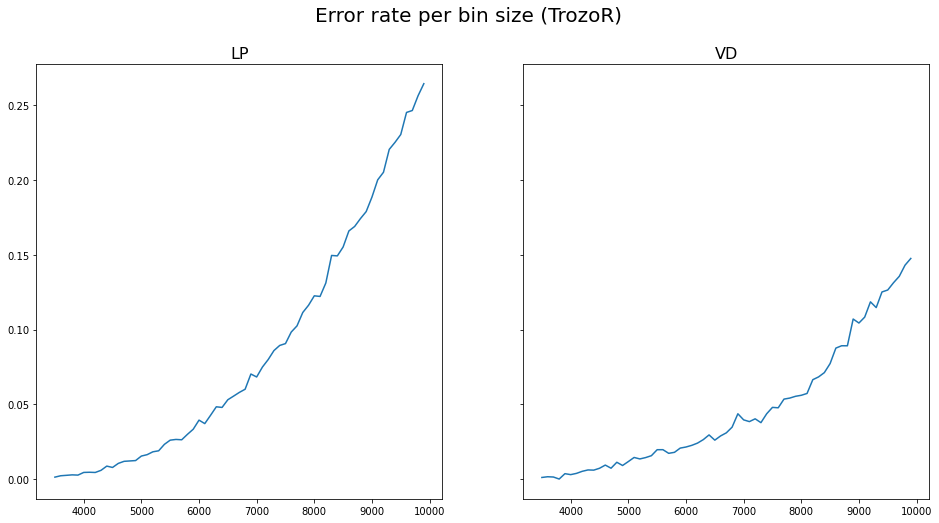

In [18]:
lp_errors_C, vd_errors_C = get_errors_rate_per_neuron(trozoC, 'bursts', 'TrozoC', range(3500,10000, 100))
lp_errors_G, vd_errors_G = get_errors_rate_per_neuron(trozoG, 'bursts', 'TrozoG', range(3500,10000, 100))
lp_errors_R, vd_errors_R = get_errors_rate_per_neuron(trozoR, 'bursts', 'TrozoR', range(3500,10000, 100))

In [38]:
bin_size = range(3500,10000, 100)

#bin_size = range(1,601)
lp_bins_C, vd_bins_C = compute_signal_by_bins(bin_size, chunk = trozoC, coding = 'bursts')
lp_bins_G, vd_bins_G = compute_signal_by_bins(bin_size, chunk = trozoG, coding = 'bursts')
lp_bins_R, vd_bins_R = compute_signal_by_bins(bin_size, chunk = trozoR, coding = 'bursts')

#### Palabras fijas

In [39]:
word_size = range(1,9)
information_C = compute_information(word_size, bin_size, lp_bins_C, vd_bins_C, True)
information_G = compute_information(word_size, bin_size, lp_bins_G, vd_bins_G, True)
information_R = compute_information(word_size, bin_size, lp_bins_R, vd_bins_R, True)

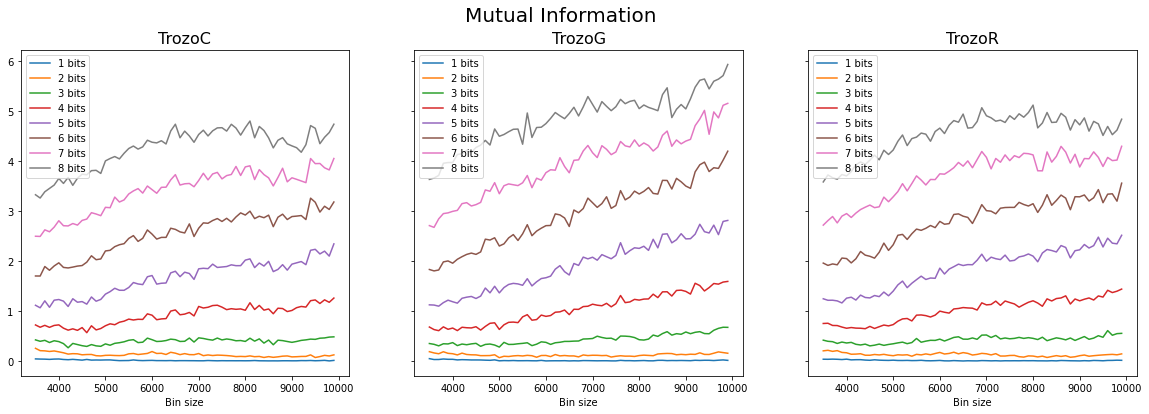

In [40]:
plot_mutual_information(information_C, information_G, information_R, word_size, bin_size)

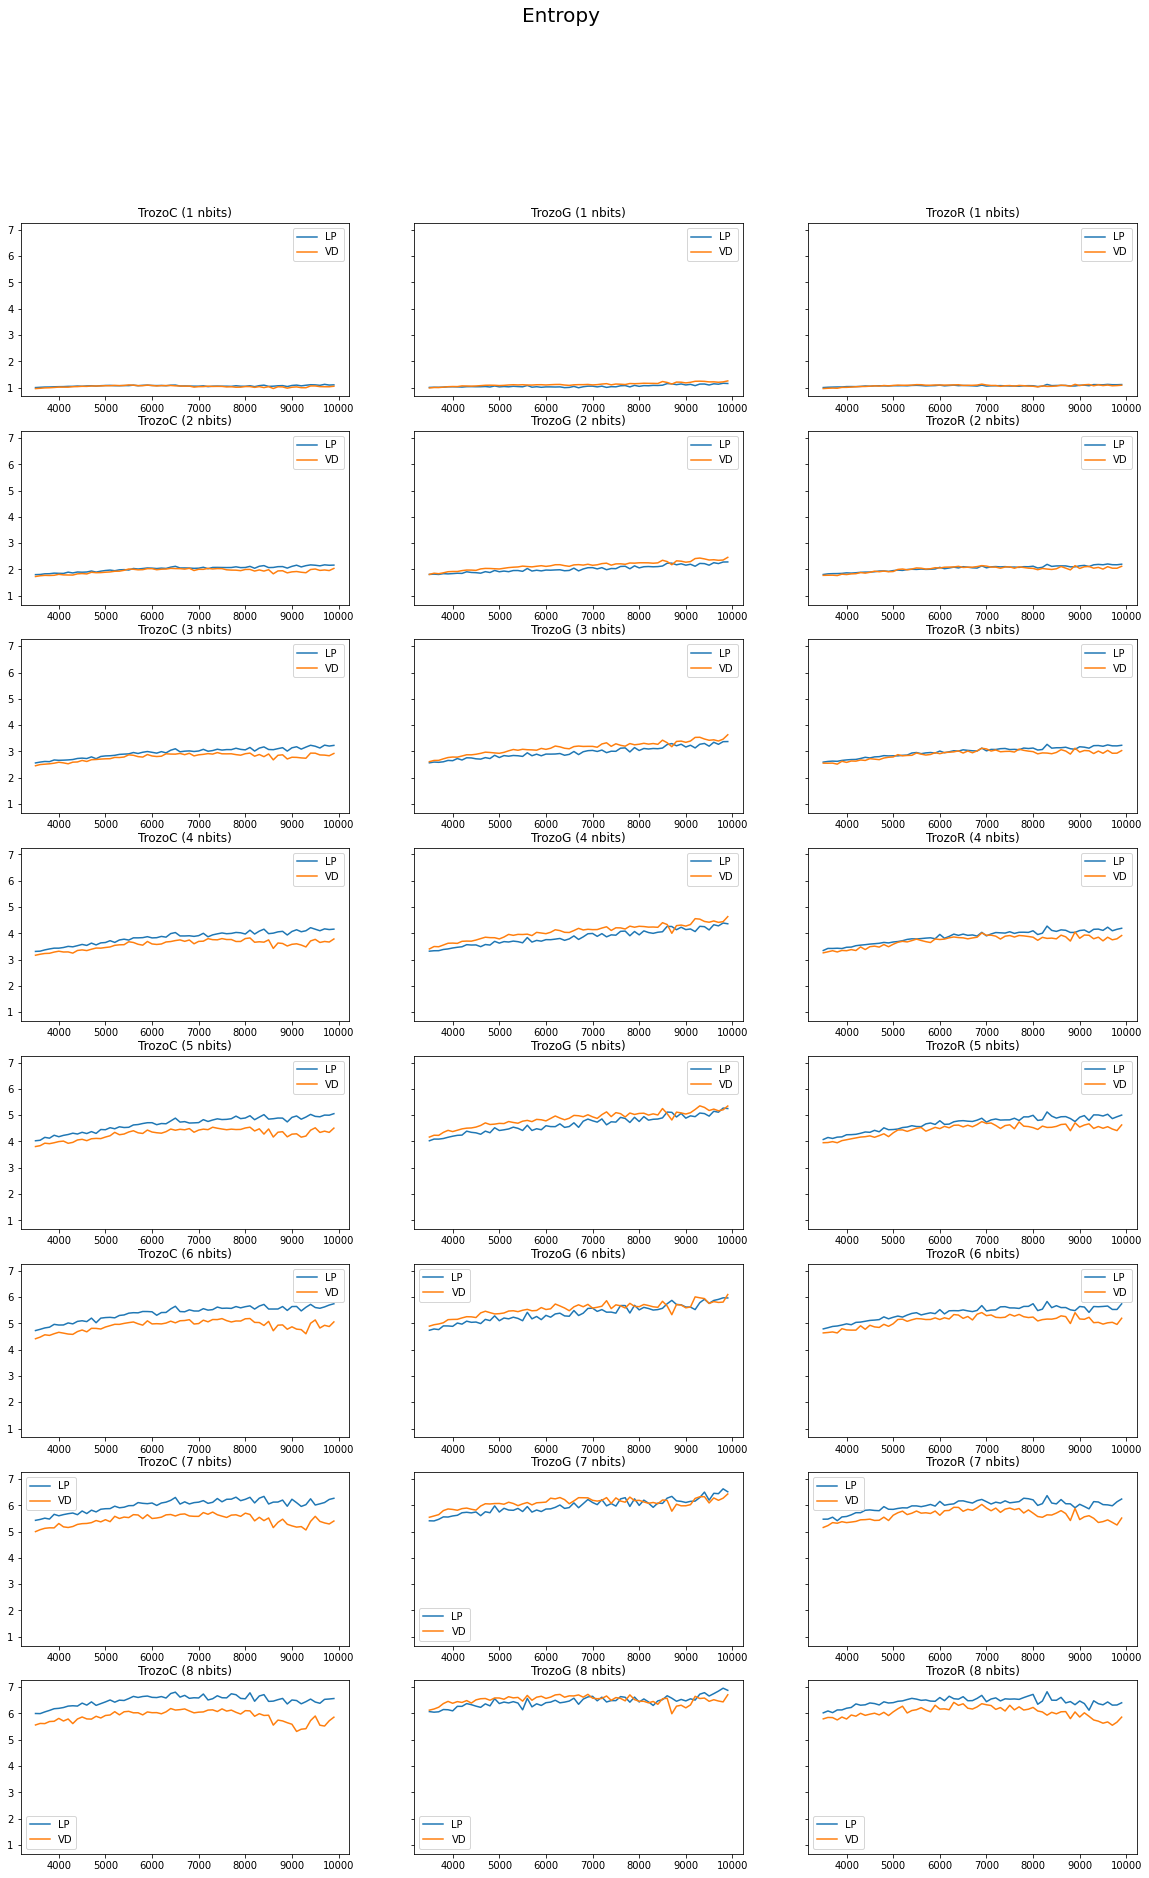

In [41]:
plot_entropia(information_C, information_G, information_R, word_size, bin_size)

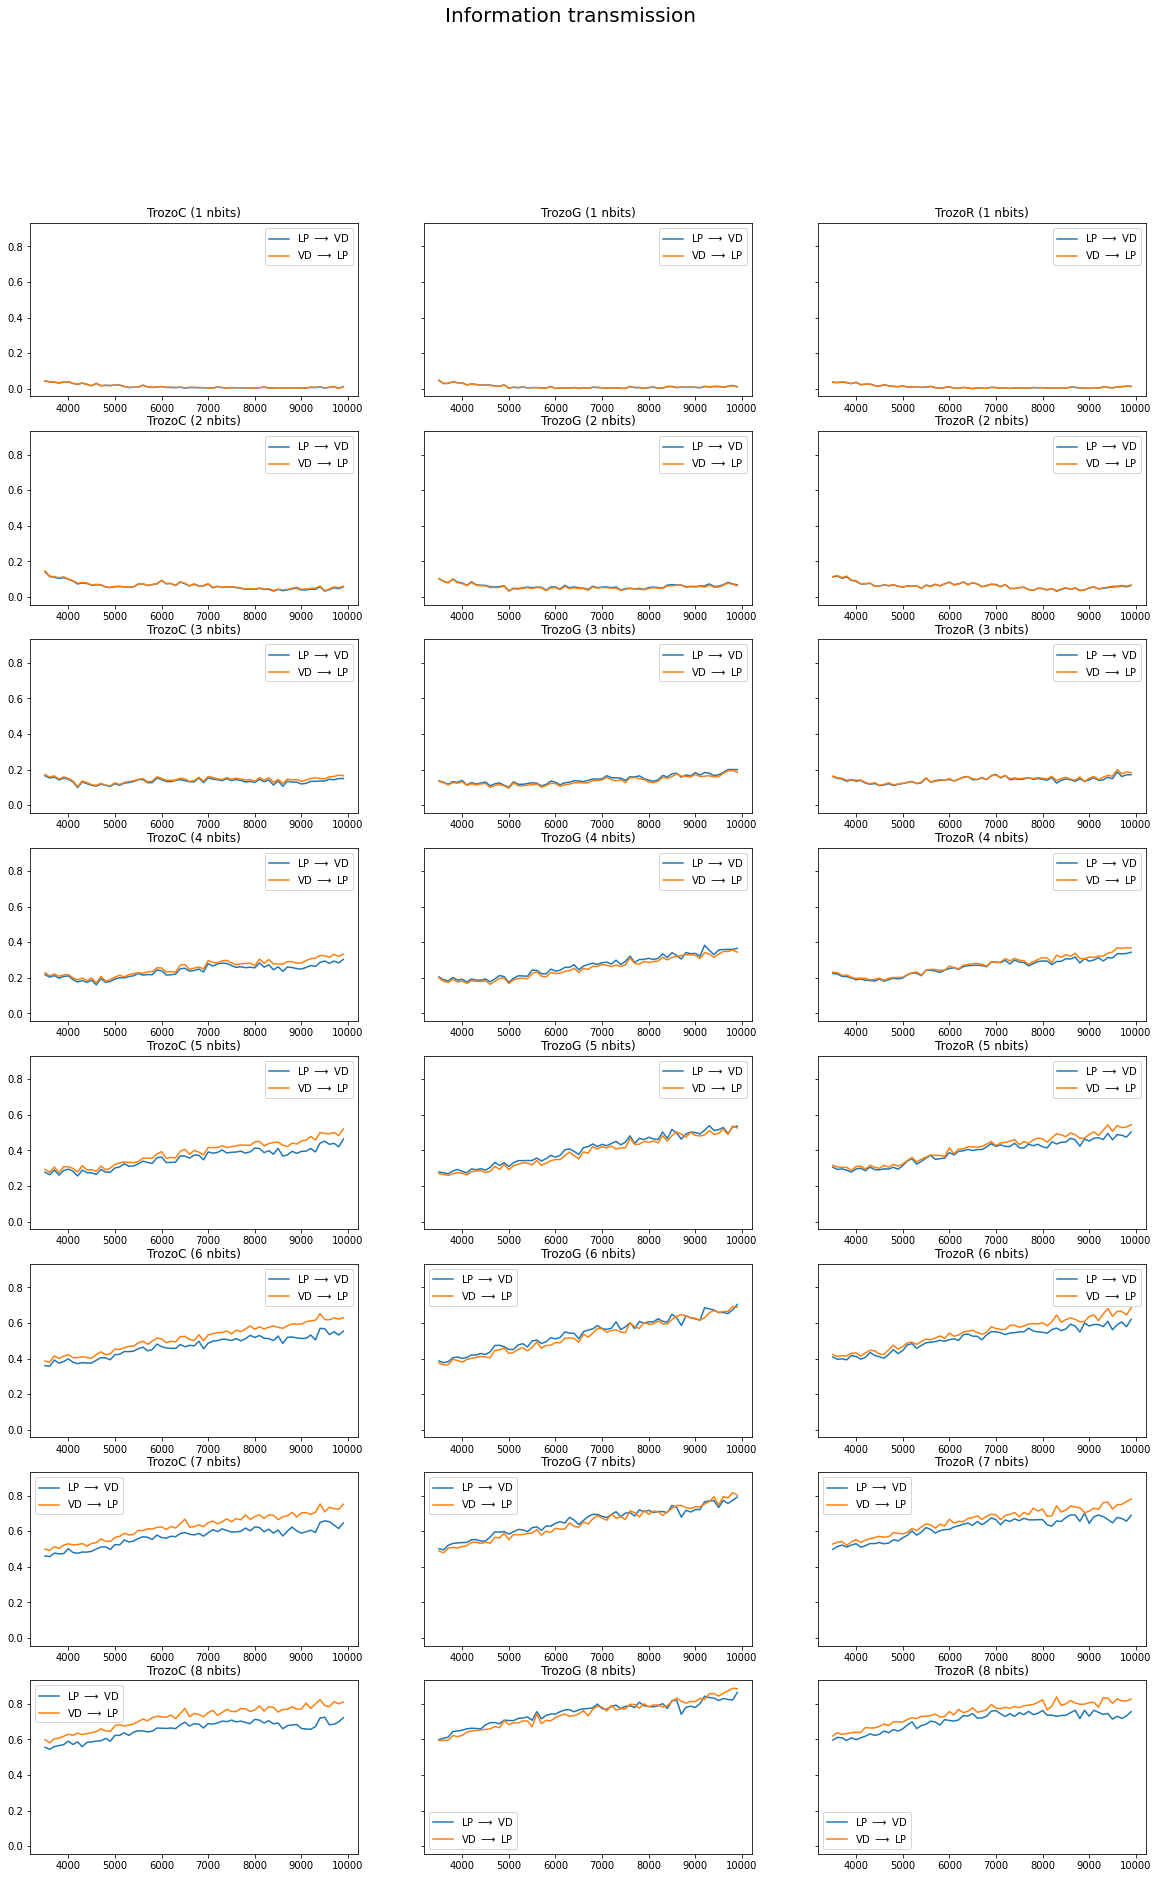

In [42]:
plot_transfer_info(information_C, information_G, information_R, word_size, bin_size)

#### Palabras deslizantes

In [43]:
word_size = range(1,9)
information_C = compute_information(word_size, bin_size, lp_bins_C, vd_bins_C, False)
information_G = compute_information(word_size, bin_size, lp_bins_G, vd_bins_G, False)
information_R = compute_information(word_size, bin_size, lp_bins_R, vd_bins_R, False)

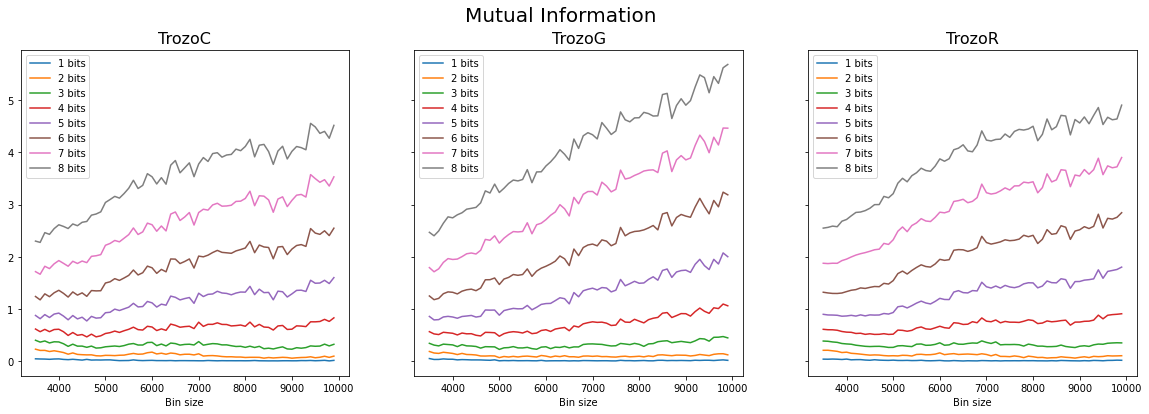

In [44]:
plot_mutual_information(information_C, information_G, information_R, word_size, bin_size)

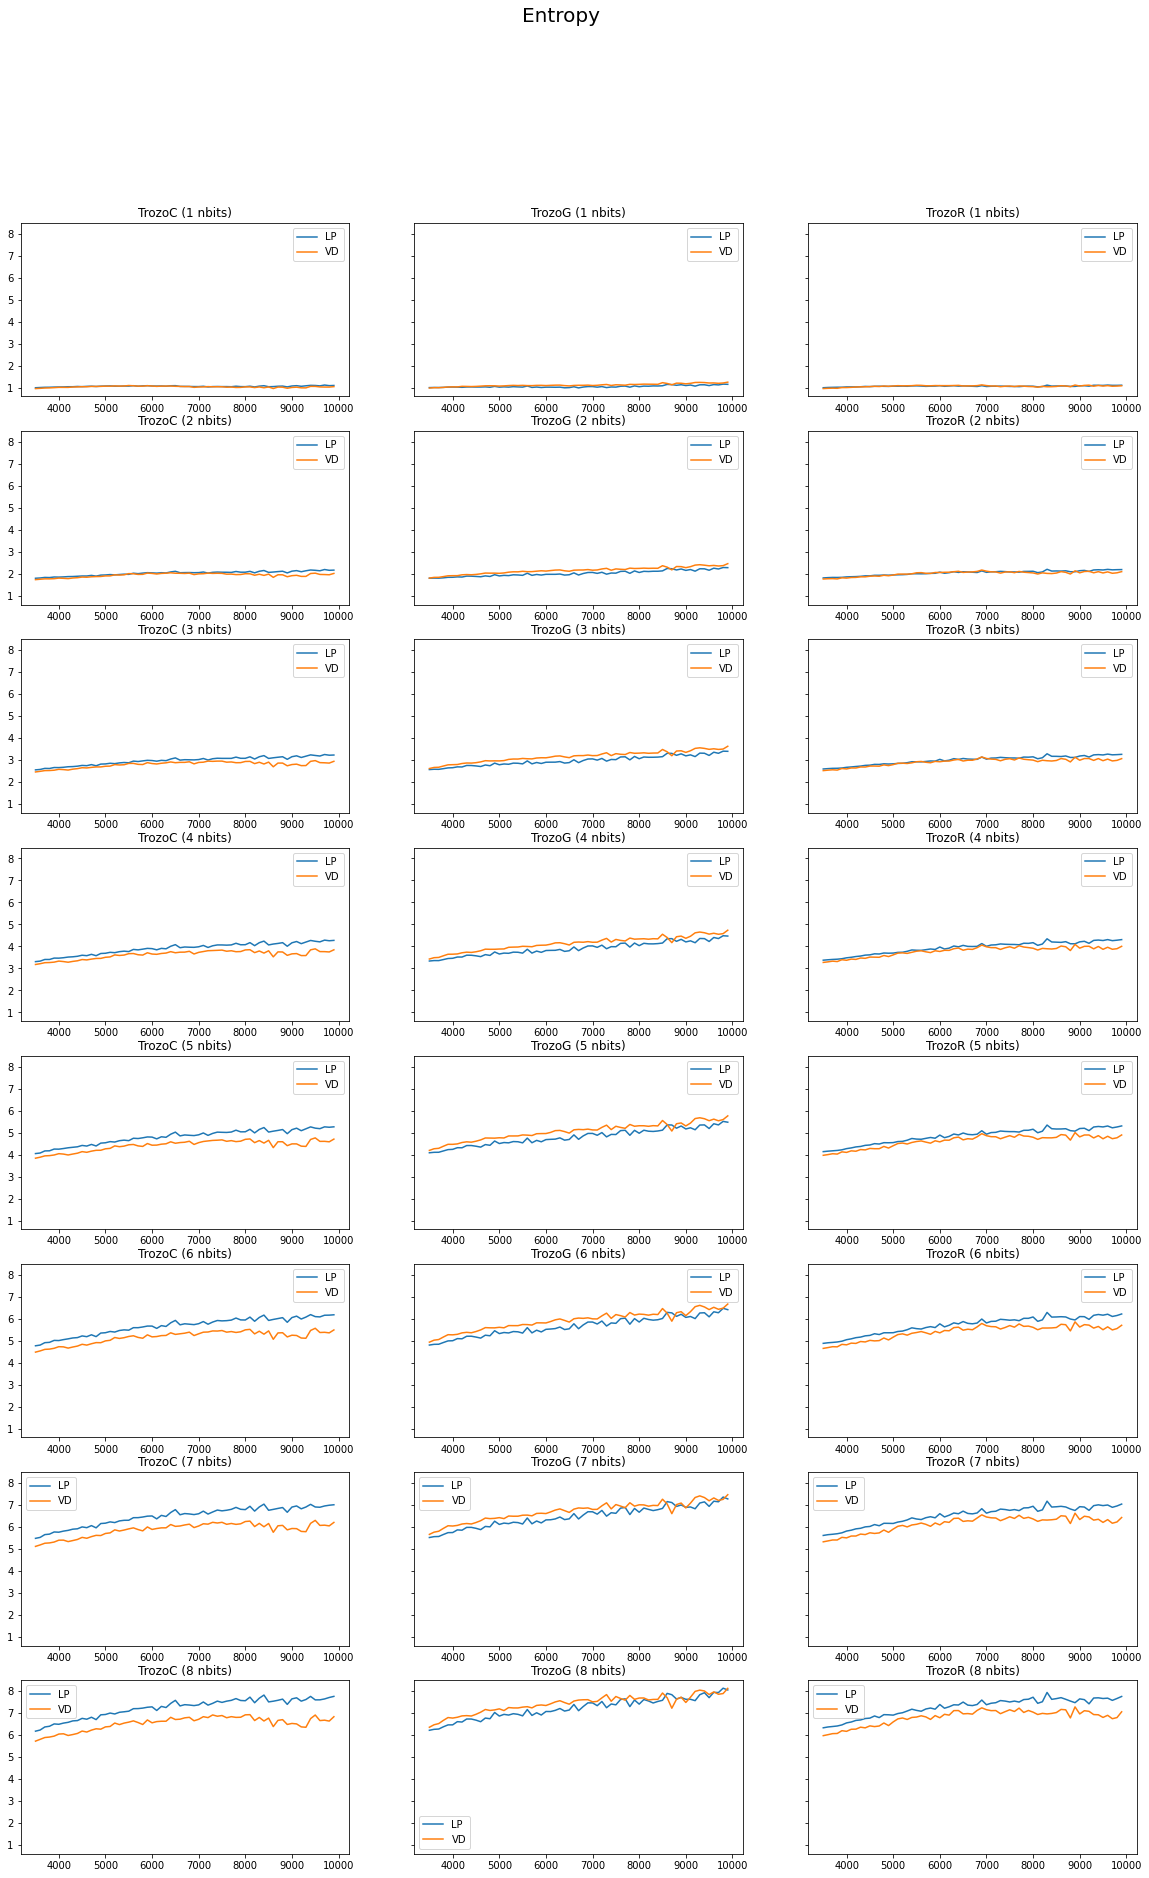

In [45]:
plot_entropia(information_C, information_G, information_R, word_size, bin_size)

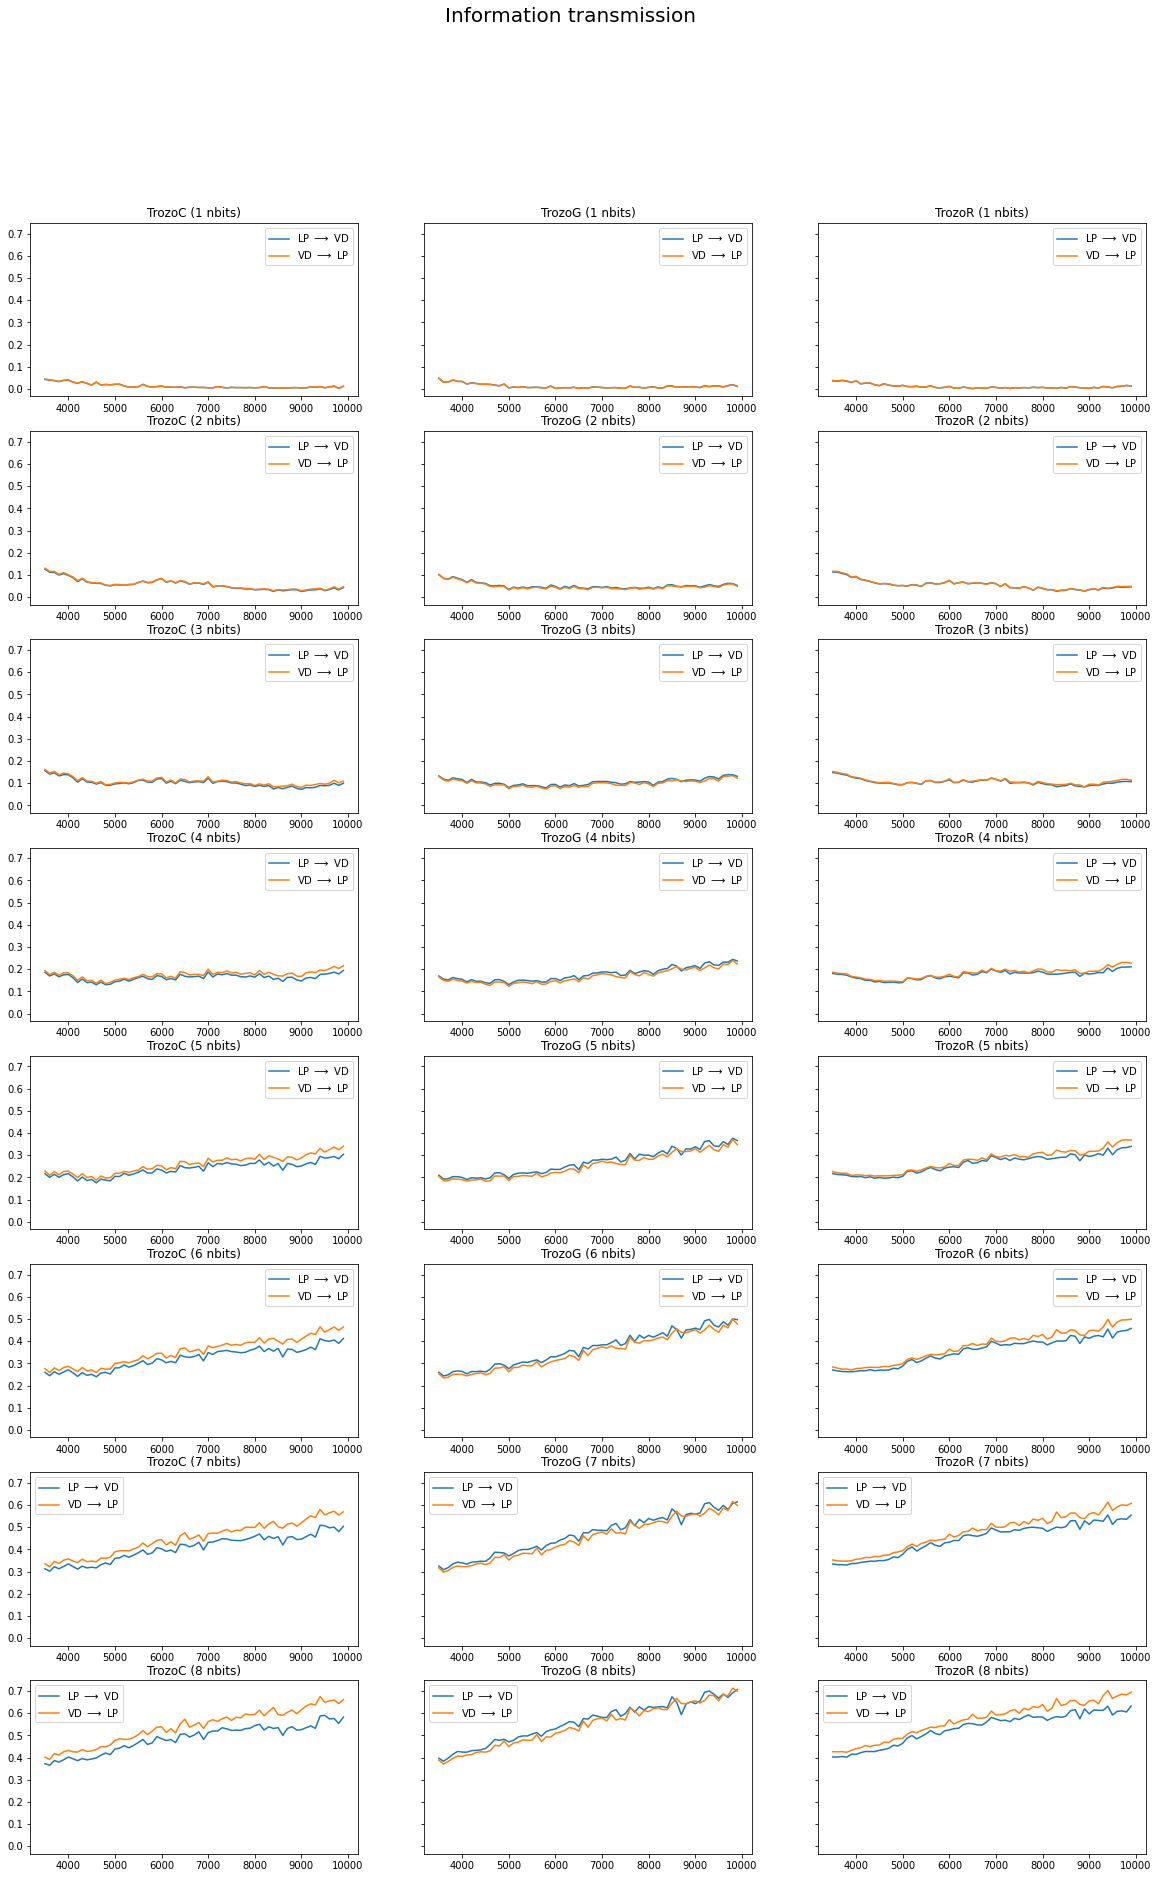

In [46]:
plot_transfer_info(information_C, information_G, information_R, word_size, bin_size)

# AQUI ME HE QUEDADO


# ESTOY LIMPIANDO POR AQUI

In [48]:
def compute_mi_1(lp_bins, vd_bins, bin_sizes):
    """

    """
    nbits = 1
    mi, elp, evd = [], [], []
    for bin_size in bin_sizes:
        lp_words = to_words(lp_bins[bin_size], nbits, nbits)
        vd_words = to_words(vd_bins[bin_size], nbits, nbits)
        m_i, e_lp, e_vd = MI(lp_words,vd_words)
        mi.append(m_i)
        elp.append(e_lp)
        evd.append(e_vd)
    mi = np.array(mi)
    elp = np.array(elp)
    evd = np.array(evd)
    ti_lp_vd = mi/elp
    ti_vd_lp = mi/evd
    return mi, elp, evd, ti_lp_vd, ti_vd_lp

# TROZO C
mi, elp, evd, ti_lp_vd, ti_vd_lp = compute_mi_1(lp_bins_C, vd_bins_C, range(1,201))

KeyError: 1

In [49]:
def plot_mi_en_tr(mi, elp, evd, ti_lp_vd, ti_vd_lp, bin_sizes):
    """
    
    """

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(16, 8)
    plt.suptitle(f'Control information (1 bit)', fontsize=20)

    ax1.plot(bin_sizes, mi, lw=0.9)
    ax1.set_title("MI", fontsize=16)
    ax1.set_xlabel("Bin size")

    ax2.plot(bin_sizes, elp, lw=0.9, label='LP Entropy')
    ax2.plot(bin_sizes, evd,'tab:orange', label='VD Entropy', lw=0.9)
    ax2.set_title("Entropy", fontsize=16)
    ax2.set_xlabel("Bin size")
    ax2.legend()

    ax3.plot(bin_sizes, ti_lp_vd, label = r'LP $\longrightarrow$ VD')
    ax3.plot(bin_sizes, ti_vd_lp, label = r'VD $\longrightarrow$ LP')
    ax3.set_title('Information transmission', fontsize=16)
    ax3.set_xlabel("Bin size")
    ax3.legend()

plot_mi_en_tr(mi, elp, evd, ti_lp_vd, ti_vd_lp, range(1,201))

NameError: name 'mi' is not defined

### Para cada tamaño de palabra

In [ ]:
#TROZO C

bin_sizes = range(1,601)
nbits_size = range(1,9)
mi, elp, evd, ti_lp_vd, ti_vd_lp  = {},{},{},{},{}
for nbits in nbits_size:
    mi_l, elp_l, evd_l = [], [], []
    for bin_size in bin_sizes:
        lp_words = to_words(lp_bins_C[bin_size], nbits, nbits)
        vd_words = to_words(vd_bins_C[bin_size], nbits, nbits)
        m_i, e_lp, e_vd = MI(lp_words,vd_words)
        mi_l.append(m_i)
        elp_l.append(e_lp)
        evd_l.append(e_vd)
    mi[nbits] = np.array(mi_l)
    elp[nbits] = np.array(elp_l)
    evd[nbits] = np.array(evd_l)
    ti_lp_vd[nbits] = np.array(mi_l)/np.array(elp_l)
    ti_vd_lp[nbits] = np.array(mi_l)/np.array(evd_l)

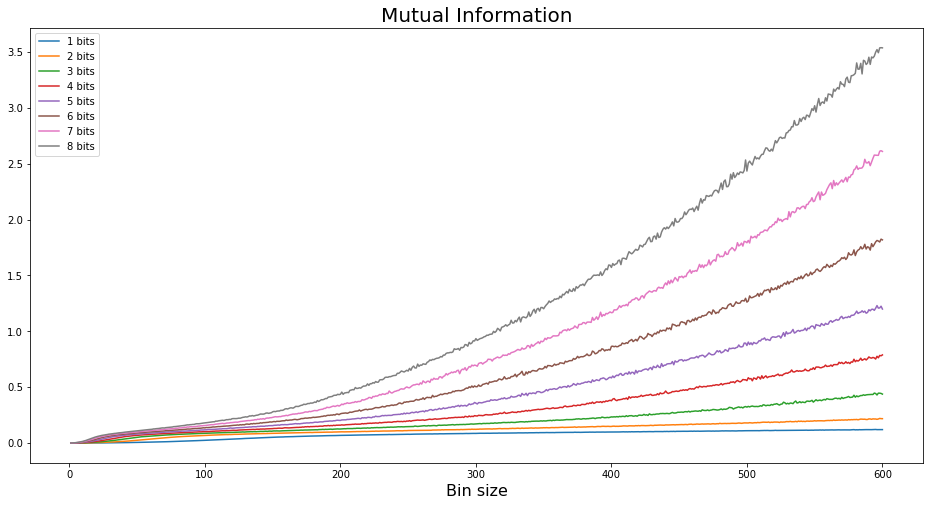

In [ ]:
plt.figure(figsize=(16, 8))
plt.title("Mutual Information", fontsize=20)
plt.xlabel("Bin size", fontsize=16)
for nbits in nbits_size:
    plt.plot(bin_sizes, mi[nbits], label = f"{nbits} bits")
plt.legend()
plt.show()

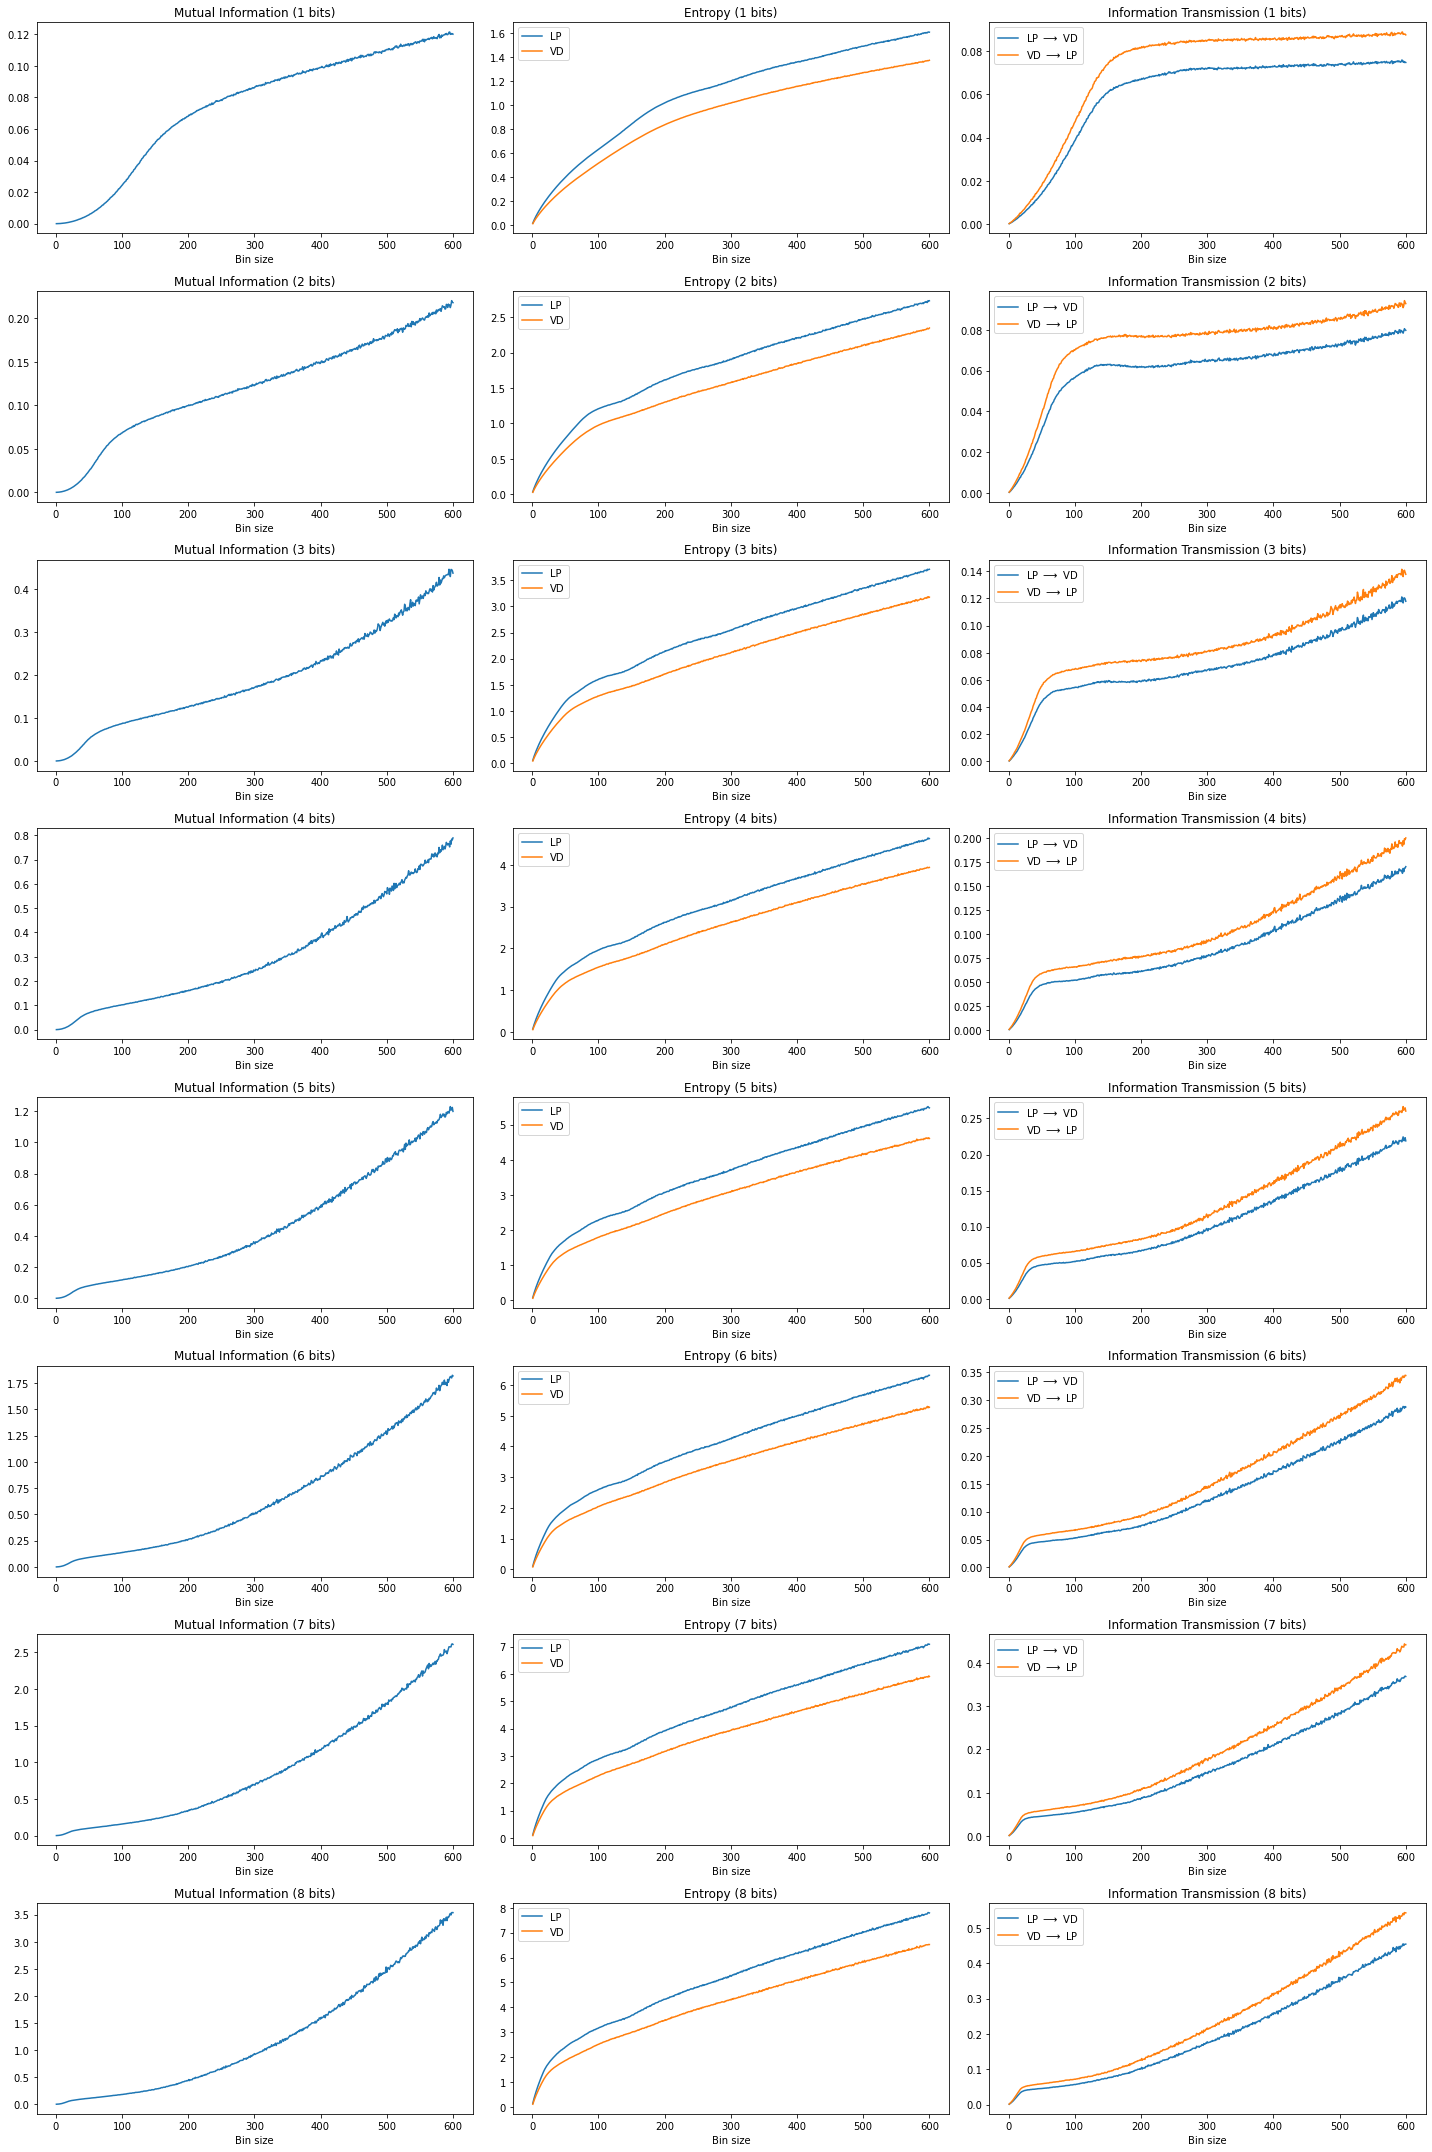

In [ ]:
#Trozo C

fig, axes = plt.subplots(len(nbits_size), 3, figsize=(20, 30))

for nbits,row in enumerate(axes):
    x = np.random.normal(0, 1, 100).cumsum()
    y = np.random.normal(0, 0.5, 100).cumsum()
    row[0].plot(bin_sizes,mi[nbits+1])
    row[0].set_title(f"Mutual Information ({nbits+1} bits)")
    row[0].set_xlabel("Bin size")

    row[1].plot(bin_sizes,elp[nbits+1],label='LP')
    row[1].plot(bin_sizes,evd[nbits+1],label='VD')
    row[1].set_title(f"Entropy ({nbits+1} bits)")
    row[1].set_xlabel("Bin size")
    row[1].legend()
    
    row[2].plot(bin_sizes, ti_lp_vd[nbits+1], label = r'LP $\longrightarrow$ VD')
    row[2].plot(bin_sizes, ti_vd_lp[nbits+1], label = r'VD $\longrightarrow$ LP')
    row[2].set_title(f'Information Transmission ({nbits+1} bits)')
    row[2].set_xlabel("Bin size")
    row[2].legend()
    
fig.tight_layout()
    
plt.show()

### REVISAR ESTO --- Codificación palabras con desplazamiento solapantes

In [ ]:
bin_sizes = range(1,81)
nbits_size = range(1,9)
mi_s, elp_s, evd_s, ti_lp_vd_s, ti_vd_lp_s  = {},{},{},{},{}
for nbits in nbits_size:
    mi_l, elp_l, evd_l = [], [], []
    for bin_size in bin_sizes:
        lp_words = to_words(lp_bins[bin_size], nbits, 1)
        vd_words = to_words(vd_bins[bin_size], nbits, 1)
        m_i, e_lp, e_vd = MI(lp_words,vd_words)
        mi_l.append(m_i)
        elp_l.append(e_lp)
        evd_l.append(e_vd)
    mi_s[nbits] = np.array(mi_l)
    elp_s[nbits] = np.array(elp_l)
    evd_s[nbits] = np.array(evd_l)
    ti_lp_vd_s[nbits] = np.array(mi_l)/np.array(elp_l)
    ti_vd_lp_s[nbits] = np.array(mi_l)/np.array(evd_l)

In [ ]:
plt.figure(figsize=(8, 6))
plt.title("MI")
plt.xlabel("Tamaño ventana")
for nbits in nbits_size:
    plt.plot(bin_sizes,mi_s[nbits], label = f"{nbits} bits")
plt.legend()
plt.show()

In [ ]:
fig, axes = plt.subplots(len(nbits_size), 3, figsize=(20, 30))

for nbits,row in enumerate(axes):
    x = np.random.normal(0, 1, 100).cumsum()
    y = np.random.normal(0, 0.5, 100).cumsum()
    row[0].plot(bin_sizes,mi_s[nbits+1])
    row[0].set_title(f"Mutual Information ({nbits+1} bits)")

    row[1].plot(bin_sizes,elp_s[nbits+1],label='LP')
    row[1].plot(bin_sizes,evd_s[nbits+1],label='VD')
    row[1].set_title(f"Entropy ({nbits+1} bits)")
    row[1].legend()
    
    row[2].plot(bin_sizes,ti_lp_vd_s[nbits+1],label = r'LP $\longrigtharrow$ VD')
    row[2].plot(bin_sizes,ti_vd_lp_s[nbits+1],label = r'VD $\longrigtharrow$ LP')
    row[2].set_title(f'Information transmission ({nbits+1} bits)')
    row[2].legend()
    
plt.show()